# Part 1: Install and Import Necessary Libraries

First, install all required Python libraries

In [1]:
# Install necessary libraries
import subprocess
import sys

packages = ['scikit-learn', 'networkx', 'pandas', 'numpy', 'matplotlib']

for package in packages:
    try:
        __import__(package.replace('-', '_'))
        print(f"✓ {package} installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installed")

# Import necessary libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import time
import warnings
import os
from collections import defaultdict

warnings.filterwarnings('ignore')

# Set matplotlib display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

Installing scikit-learn...
✓ scikit-learn installed
✓ networkx installed
✓ pandas installed
✓ numpy installed
✓ matplotlib installed
All libraries imported successfully!


# Part 2: Read and Parse Network Traffic Data

In [2]:
## Set data file paths
data_dir = '../data'
labeled_file = os.path.join(data_dir, 'annotated-trace.csv')
unlabeled_file = os.path.join(data_dir, 'not-annotated-trace.csv')

# Check if files exist
if os.path.exists(labeled_file):
    print(f"✓ Found labeled data: {labeled_file}")
else:
    print(f"✗ Labeled data not found: {labeled_file}")

if os.path.exists(unlabeled_file):
    print(f"✓ Found unlabeled data: {unlabeled_file}")
else:
    print(f"✗ Unlabeled data not found: {unlabeled_file}")

# Data parsing and loading functions
def _to_binary_label(label_str):
    """Map various label tokens to {0,1}. Return None if unknown."""
    if label_str is None:
        return None
    s = str(label_str).strip().strip('"\'').lower()
    map0 = {"0", "normal", "benign", "benignware", "good", "legit", "legitimate", "clean"}
    map1 = {"1", "malicious", "malware", "attack", "attacker", "anomalous", "anomaly", "botnet", "bad", "infected"}
    if s in map0:
        return 0
    if s in map1:
        return 1
    try:
        val = int(s)
        if val in (0, 1):
            return val
    except Exception:
        pass
    return None

def parse_network_flow(flow_string):
    """
    Parse network traffic string
    Format: srcIP,dstIP,protocol,sPort,dPort[,label]
    """
    parts = flow_string.strip().split(',')

    if len(parts) < 5:
        return None

    try:
        src_ip = int(parts[0])
        dst_ip = int(parts[1])
        protocol = int(parts[2])
        src_port = int(parts[3])
        dst_port = int(parts[4])

        # Handle label (optional)
        label = None
        if len(parts) >= 6:
            label = _to_binary_label(parts[5])

        return {
            'src_ip': src_ip,
            'dst_ip': dst_ip,
            'protocol': protocol,
            'src_port': src_port,
            'dst_port': dst_port,
            'label': label
        }
    except Exception:
        return None

def load_network_data(filepath, has_labels=True):
    """Load network traffic data"""
    flows = []
    host_flows = defaultdict(list)

    if not os.path.exists(filepath):
        print(f"Warning: File {filepath} does not exist")
        return flows, host_flows

    with open(filepath, 'r') as f:
        for line_num, line in enumerate(f, 1):
            flow = parse_network_flow(line)
            if flow:
                flows.append(flow)
                host_flows[flow['src_ip']].append(flow)

    print(f"Loaded {len(flows)} traffic records from {filepath}")
    print(f"Involving {len(host_flows)} source IP addresses")

    return flows, host_flows

# Load labeled and unlabeled data
labeled_flows, labeled_hosts = load_network_data(labeled_file, has_labels=True)
unlabeled_flows, unlabeled_hosts = load_network_data(unlabeled_file, has_labels=False)

✓ Found labeled data: ../data/annotated-trace.csv
✓ Found unlabeled data: ../data/not-annotated-trace.csv
Loaded 10070 traffic records from ../data/annotated-trace.csv
Involving 1001 source IP addresses
Loaded 10070 traffic records from ../data/not-annotated-trace.csv
Involving 1001 source IP addresses


# Part 3: Build End-Host Graph Features (Graphlet)

### Concept Explanation
A Graphlet is a small graph representation for each source IP address. Nodes represent elements in communication (source IP, destination IP, protocol, ports, etc.), and edges represent relationships between these elements. This graph encodes the communication characteristics of that host.

Built graphlets for 1001 hosts
Built graphlets for 1002 hosts
Displaying some host graphlets from labeled data:
✓ Displaying graphlet for normal host 742


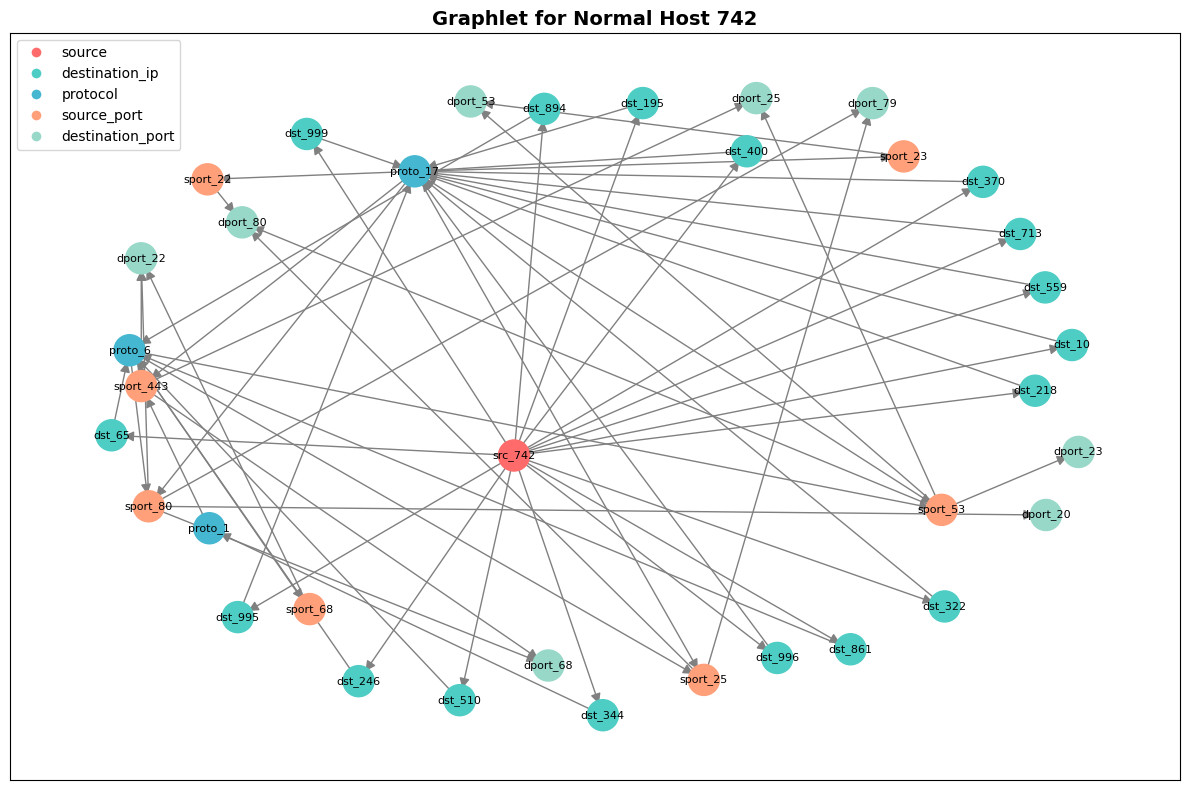

✓ Displaying graphlet for malicious host 1935


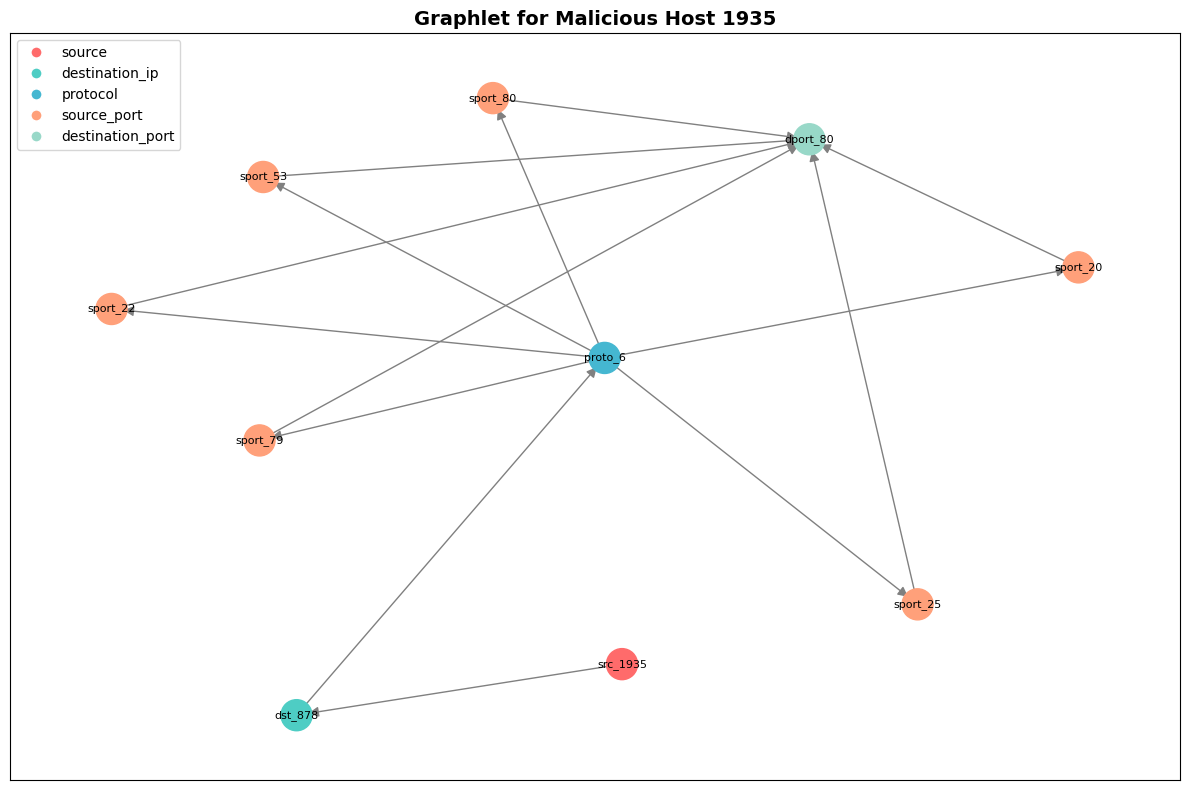

In [3]:
class GraphletConstructor:
    """Class for constructing end-host Graphlets"""

    def __init__(self):
        self.host_graphlets = {}
        self.host_labels = {}

    def build_graphlet_for_host(self, host_ip, flows):
        """
        Build a graphlet for a source IP address

        Parameters:
        -----------
        host_ip : int
            Source IP address
        flows : list
            List of all traffic records for this host
        """
        if not flows:
            return None

        # Create a directed graph
        G = nx.DiGraph()

        # Add source IP as central node
        G.add_node(f"src_{host_ip}", type='source')

        # Add nodes and edges for each traffic record
        for i, flow in enumerate(flows):
            # Create nodes
            dst_node = f"dst_{flow['dst_ip']}"
            proto_node = f"proto_{flow['protocol']}"
            sport_node = f"sport_{flow['src_port']}"
            dport_node = f"dport_{flow['dst_port']}"

            # Add nodes to graph
            G.add_node(dst_node, type='destination_ip')
            G.add_node(proto_node, type='protocol')
            G.add_node(sport_node, type='source_port')
            G.add_node(dport_node, type='destination_port')

            # Add edges: source IP -> destination IP -> protocol -> source port -> destination port
            G.add_edge(f"src_{host_ip}", dst_node, flow_id=i)
            G.add_edge(dst_node, proto_node, flow_id=i)
            G.add_edge(proto_node, sport_node, flow_id=i)
            G.add_edge(sport_node, dport_node, flow_id=i)

        self.host_graphlets[host_ip] = G

        # Record host label (majority label)
        labels = [f['label'] for f in flows if f['label'] is not None]
        if labels:
            self.host_labels[host_ip] = max(set(labels), key=labels.count)

        return G

    def build_all_graphlets(self, host_flows_dict):
        """Build graphlets for all hosts"""
        for host_ip, flows in host_flows_dict.items():
            self.build_graphlet_for_host(host_ip, flows)

        print(f"Built graphlets for {len(self.host_graphlets)} hosts")
        return self.host_graphlets

    def visualize_graphlet(self, host_ip, title=None):
        """Visualize a host's graphlet"""
        if host_ip not in self.host_graphlets:
            print(f"Error: Graphlet for host {host_ip} not found")
            return

        G = self.host_graphlets[host_ip]

        fig, ax = plt.subplots(figsize=(12, 8))

        # Use spring layout
        pos = nx.spring_layout(G, k=2, iterations=50)

        # Color by node type
        node_colors = []
        color_map = {
            'source': '#FF6B6B',
            'destination_ip': '#4ECDC4',
            'protocol': '#45B7D1',
            'source_port': '#FFA07A',
            'destination_port': '#98D8C8'
        }

        for node in G.nodes():
            node_type = G.nodes[node].get('type', 'unknown')
            node_colors.append(color_map.get(node_type, '#CCCCCC'))

        # Draw network
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                             node_size=500, ax=ax)
        nx.draw_networkx_edges(G, pos, edge_color='gray', 
                             arrows=True, arrowsize=15, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

        if title is None:
            label_str = f"(Label: {'Normal' if self.host_labels.get(host_ip) == 0 else 'Malicious'})" \
                       if host_ip in self.host_labels else "(Unlabeled)"
            title = f"Graphlet for Host {host_ip} {label_str}"

        ax.set_title(title, fontsize=14, fontweight='bold')

        # Add legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color_map[k], 
                                    markersize=8, label=k) 
                           for k in ['source', 'destination_ip', 'protocol', 
                                    'source_port', 'destination_port']]
        ax.legend(handles=legend_elements, loc='upper left')

        plt.tight_layout()
        plt.show()

# Build all graphlets
constructor = GraphletConstructor()
constructor.build_all_graphlets(labeled_hosts)
constructor.build_all_graphlets(unlabeled_hosts)

# Visualize some example graphlets
print("Displaying some host graphlets from labeled data:")

# Display one normal host and one malicious host
normal_hosts = [h for h, l in constructor.host_labels.items() if l == 0]
malicious_hosts = [h for h, l in constructor.host_labels.items() if l == 1]

if normal_hosts:
    print(f"✓ Displaying graphlet for normal host {normal_hosts[0]}")
    constructor.visualize_graphlet(normal_hosts[0], title=f"Graphlet for Normal Host {normal_hosts[0]}")

if malicious_hosts:
    print(f"✓ Displaying graphlet for malicious host {malicious_hosts[0]}")
    constructor.visualize_graphlet(malicious_hosts[0], title=f"Graphlet for Malicious Host {malicious_hosts[0]}")

# Part 4: Implement Random Walk Kernel Function

### Random Walk Kernel Principle
The random walk kernel measures similarity between two graphs by counting the number of identical random walk paths.
- A random walk of length k is a sequence of k+1 nodes in the graph
- Two identical random walk sequences increase the similarity score
- This method effectively captures structural features of the graph

In [4]:
class RandomWalkKernel:
    """Random walk kernel implementation"""

    def __init__(self, walk_length=4):
        """
        Initialize random walk kernel

        Parameters:
        -----------
        walk_length : int
            Length of random walks (number of edges)
        """
        self.walk_length = walk_length
        self.feature_map = {}
        self.feature_count = 0

    def generate_random_walks(self, graph, start_node, num_walks=10):
        """
        Generate random walks from a starting node

        Parameters:
        -----------
        graph : networkx.DiGraph
            Input graph
        start_node : str
            Starting node
        num_walks : int
            Number of walks to generate

        Returns:
        --------
        walks : list
            List of random walks, each walk is a tuple of node sequence
        """
        walks = []

        for _ in range(num_walks):
            walk = [start_node]
            current = start_node

            for _ in range(self.walk_length):
                # Get all successor nodes of current node
                neighbors = list(graph.successors(current))

                if not neighbors:
                    break

                # Randomly select a neighboring node
                next_node = np.random.choice(neighbors)
                walk.append(next_node)
                current = next_node

            # Only record complete walks (length = walk_length + 1)
            if len(walk) == self.walk_length + 1:
                walks.append(tuple(walk))

        return walks

    def generate_all_walks(self, graph, num_walks_per_node=5):
        """
        Generate random walks for all nodes in the graph

        Parameters:
        -----------
        graph : networkx.DiGraph
            Input graph
        num_walks_per_node : int
            Number of walks per node

        Returns:
        --------
        all_walks : list
            All random walks
        """
        all_walks = []
        nodes = list(graph.nodes())

        for node in nodes:
            walks = self.generate_random_walks(graph, node, num_walks_per_node)
            all_walks.extend(walks)

        return all_walks

    def walks_to_features(self, walks, use_hashing=False, hash_dim=1024):
        """
        Convert random walks to feature vector

        Parameters:
        -----------
        walks : list
            List of random walks
        use_hashing : bool
            Whether to use hashing (suitable for high-dimensional features)
        hash_dim : int
            Hash dimension

        Returns:
        --------
        features : numpy.ndarray
            Feature vector
        """
        if use_hashing:
            # Use hashing trick to create fixed-dimension feature vector
            features = np.zeros(hash_dim)

            for walk in walks:
                # Convert walk to string and hash
                walk_str = '-'.join(str(node) for node in walk)
                idx = hash(walk_str) % hash_dim
                features[idx] += 1

            return features
        else:
            # Create feature map
            feature_dict = {}

            for walk in walks:
                walk_str = '-'.join(str(node) for node in walk)

                if walk_str not in self.feature_map:
                    self.feature_map[walk_str] = self.feature_count
                    self.feature_count += 1

                idx = self.feature_map[walk_str]
                feature_dict[idx] = feature_dict.get(idx, 0) + 1

            # Convert to dense vector
            features = np.zeros(self.feature_count)
            for idx, count in feature_dict.items():
                features[idx] = count

            return features
        
    def compute_walk_kernel(self, graph1, graph2, num_walks_per_node=5):
        """
        Note: This specific function is no longer called by the optimized 
        matrix function to avoid overhead, but kept for individual pairs.
        """
        walks1 = set(self.generate_all_walks(graph1, num_walks_per_node))
        walks2 = set(self.generate_all_walks(graph2, num_walks_per_node))
        return float(len(walks1.intersection(walks2)))

    def compute_kernel_matrix(self, graphs, num_walks_per_node=5):
            """
            Optimized computation of the kernel matrix.
            Pre-calculates walks for each graph once to avoid O(N^2) redundancy.
            """
            n = len(graphs)
            K = np.zeros((n, n))

            # --- STEP 1: Pre-calculate all walks (O(N)) ---
            print(f"Pre-calculating walks for {n} graphs...")
            # Store walks as sets for O(1) lookups during intersection
            precomputed_walks = []
            for i, g in enumerate(graphs):
                walks = set(self.generate_all_walks(g, num_walks_per_node))
                precomputed_walks.append(walks)
                if (i + 1) % 100 == 0:
                    print(f"  Generated walks for {i + 1}/{n} graphs...")

            # --- STEP 2: Compute Matrix via Set Intersection (O(N^2)) ---
            print(f"Computing {n}x{n} kernel matrix...")
            for i in range(n):
                # Optimization: Cache the set for graph i
                w1 = precomputed_walks[i]
                for j in range(i, n):
                    # Optimization: Access precomputed set for graph j
                    w2 = precomputed_walks[j]
                    
                    # Fast set intersection
                    common_walks = len(w1.intersection(w2))
                    
                    K[i, j] = float(common_walks)
                    K[j, i] = float(common_walks) # Symmetric property

                if (i + 1) % 50 == 0:
                    print(f"  Processed row {i + 1}/{n}...")

            return K

# Initialize random walk kernel
walk_kernel = RandomWalkKernel(walk_length=4)
print("✓ Random walk kernel initialized (walk length=4)")

# Test random walk kernel
if normal_hosts and malicious_hosts:
    g1 = constructor.host_graphlets[normal_hosts[0]]
    g2 = constructor.host_graphlets[malicious_hosts[0]]

    print(f"Testing random walk kernel:")
    print(f"  Graph1 (normal host {normal_hosts[0]}): {len(g1.nodes())} nodes, {len(g1.edges())} edges")
    print(f"  Graph2 (malicious host {malicious_hosts[0]}): {len(g2.nodes())} nodes, {len(g2.edges())} edges")

    # Generate random walks
    walks1 = walk_kernel.generate_all_walks(g1, num_walks_per_node=3)
    walks2 = walk_kernel.generate_all_walks(g2, num_walks_per_node=3)

    print(f"Generated random walks:")
    print(f"  Graph1: {len(walks1)} walks")
    print(f"  Graph2: {len(walks2)} walks")

    # Show some walk examples
    print(f"irst 3 walks from Graph1:")
    for i, walk in enumerate(walks1[:3]):
        print(f"    {i+1}. {' -> '.join(str(n) for n in walk)}")

✓ Random walk kernel initialized (walk length=4)
Testing random walk kernel:
  Graph1 (normal host 742): 36 nodes, 61 edges
  Graph2 (malicious host 1935): 10 nodes, 14 edges
Generated random walks:
  Graph1: 3 walks
  Graph2: 3 walks
irst 3 walks from Graph1:
    1. src_742 -> dst_713 -> proto_17 -> sport_443 -> dport_25
    2. src_742 -> dst_510 -> proto_6 -> sport_53 -> dport_80
    3. src_742 -> dst_510 -> proto_6 -> sport_25 -> dport_79


# Part 5: Map Graph Features to High-Dimensional Space

To use SVM for classification, we need to convert each Graphlet into a feature vector. Using the feature vector generated by random walks, each dimension corresponds to a specific walk pattern.

In [5]:
print("=" * 60)
print("Feature Extraction (Direct Mapping Method)")
print("=" * 60)

feature_extractor = RandomWalkKernel(walk_length=4)

# Extract features from labeled data
X_features = []
y_labels = []
host_ids = []

print("Extracting features from labeled data...")
start_time = time.time()

for host_id, graph in constructor.host_graphlets.items():
    if host_id in constructor.host_labels:
        # Generate random walks
        walks = feature_extractor.generate_all_walks(graph, num_walks_per_node=5)

        # Convert to feature vector
        features = feature_extractor.walks_to_features(walks, use_hashing=False)

        X_features.append(features)
        y_labels.append(constructor.host_labels[host_id])
        host_ids.append(host_id)

# Standardize feature dimensions
max_dim = max(len(f) for f in X_features) if X_features else 0
X_features_padded = [np.pad(f, (0, max_dim - len(f))) for f in X_features]

X_direct = np.array(X_features_padded)
y = np.array(y_labels)

feature_time = time.time() - start_time

print(f"✓ Feature extraction complete")
print(f"  Processing time: {feature_time:.2f} seconds")
print(f"  Number of samples: {X_direct.shape[0]}")
print(f"  Feature dimension: {X_direct.shape[1]}")
print(f"  Label distribution: {np.bincount(y)}")

Feature Extraction (Direct Mapping Method)
Extracting features from labeled data...
✓ Feature extraction complete
  Processing time: 10.99 seconds
  Number of samples: 1001
  Feature dimension: 4654
  Label distribution: [1000    1]


# Part 6: Build Classification Model Using SVM (Without Kernel Trick)

### Method Explanation
Directly input feature vectors into SVM classifier using linear kernel. This is a baseline method for comparison with kernel trick method.

SVM Classifier (Without Kernel Trick)

Label strategy: strict
Strategy explanation:
  - strict: Mark host as anomaly if any anomaly traffic exists
  - threshold: Mark host as anomaly only if anomaly traffic ratio exceeds threshold
  - majority: Majority voting (may cause anomaly hosts to be mislabeled as normal)

Host label distribution:
  Normal: 941 hosts (94.0%)
  Anomaly: 60 hosts (6.0%)

Label distribution after feature extraction:
  Class distribution: {0: 941, 1: 60}
  Total samples: 1001
  Anomaly ratio: 6.0%

Attempting stratified sampling (max 50 attempts)...
  ✓ Attempt 1 successful: random_state=42

Data splitting:
  Training set: 700 samples
  Test set: 301 samples
  Training set label distribution: Normal=658, Anomaly=42
  Test set label distribution: Normal=283, Anomaly=18

Training SVM classifier...
  Class weights: balanced (automatically calculated to handle 6.0% anomaly samples)
✓ SVM training complete (time: 4.52 seconds)

SVM model information:
  Number of support 

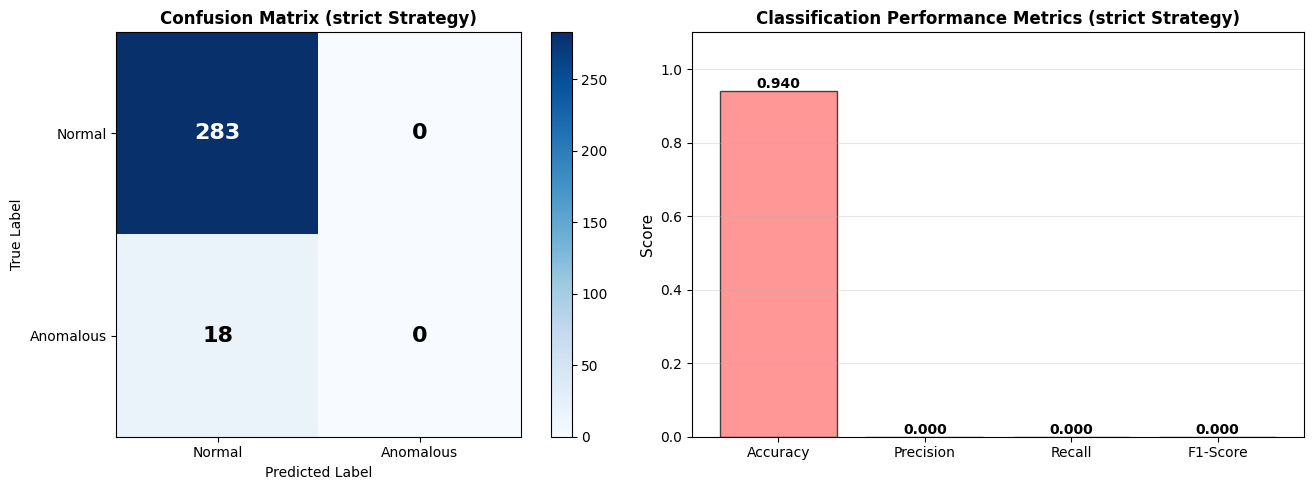

In [6]:
print("=" * 60)
print("SVM Classifier (Without Kernel Trick)")
print("=" * 60)

# -----------------------------
# Host label strategy - MODIFIED based on analysis
# Analysis shows: Out of 1001 hosts, only 1 pure anomaly host, 59 mixed-label hosts
# Majority voting strategy causes 59 hosts with anomaly traffic to be labeled as normal
# -----------------------------
label_strategy = 'strict'   # CHANGED from 'threshold' to 'strict' - recommended based on analysis
# Note: Based on analysis, 'threshold' strategy yields 22 anomaly hosts (10% threshold) or 1 anomaly host (30% threshold)
# While 'strict' strategy yields 60 anomaly hosts (6%), which is more suitable for SVM training
threshold = 0.10               # If using threshold strategy, recommended to use 10% threshold

from collections import Counter

def compute_host_labels_by_strategy(labeled_hosts_dict, majority_labels, strategy='strict', thr=0.1):
    """
    Compute host labels according to specified strategy
    
    Problems found in analysis:
    1. Majority voting strategy: 59 hosts with anomaly traffic incorrectly labeled as normal
    2. Strict strategy: Any anomaly traffic marks the host as anomaly, yielding 60 anomaly hosts (6%)
    3. Threshold strategy (10%): Yields 22 anomaly hosts (2.2%)
    """
    host_label_map = {}
    
    if strategy == 'majority':
        return dict(majority_labels)
    
    for host_id, flows in labeled_hosts_dict.items():
        labels = [f.get('label') for f in flows if f.get('label') is not None]
        if not labels:
            # fallback to majority label if existed
            if host_id in majority_labels:
                host_label_map[host_id] = majority_labels[host_id]
            continue
        
        if strategy == 'strict':
            # Strict strategy: Mark host as anomaly if any anomaly traffic exists
            # This aligns with cybersecurity context - any suspicious behavior should raise attention
            host_label_map[host_id] = 1 if any(l == 1 for l in labels) else 0
            
        elif strategy == 'threshold':
            # Threshold strategy: Mark host as anomaly only if anomaly traffic ratio exceeds threshold
            pos = sum(1 for l in labels if l == 1)
            ratio = pos / len(labels)
            host_label_map[host_id] = 1 if ratio > thr else 0
            
        else:
            # Default fallback to majority voting
            host_label_map[host_id] = max(set(labels), key=labels.count)
    
    return host_label_map

# ADDED: Print strategy explanation
print(f"\nLabel strategy: {label_strategy}")
if label_strategy == 'threshold':
    print(f"Threshold: {threshold}")
print("Strategy explanation:")
print("  - strict: Mark host as anomaly if any anomaly traffic exists")
print("  - threshold: Mark host as anomaly only if anomaly traffic ratio exceeds threshold")
print("  - majority: Majority voting (may cause anomaly hosts to be mislabeled as normal)")

# Build host label map according to strategy
host_label_map = compute_host_labels_by_strategy(labeled_hosts, constructor.host_labels, label_strategy, threshold)

# ADDED: Print label statistics
label_counts = Counter(host_label_map.values())
print(f"\nHost label distribution:")
for label, count in label_counts.items():
    label_name = "Normal" if label == 0 else "Anomaly"
    print(f"  {label_name}: {count} hosts ({count/len(host_label_map)*100:.1f}%)")

# Re-align labels to feature matrix rows using host_ids captured during feature extraction
relabel_list = []
missing = 0
for h in host_ids:
    if h in host_label_map:
        relabel_list.append(host_label_map[h])
    elif h in constructor.host_labels:
        relabel_list.append(constructor.host_labels[h])
    else:
        # shouldn't happen for labeled set, mark as normal by default
        relabel_list.append(0)
        missing += 1

y = np.array(relabel_list)

# Diagnostics - ENHANCED with more information
classes, counts = np.unique(y, return_counts=True)
print("\nLabel distribution after feature extraction:")
print("  Class distribution:", dict(zip(classes.tolist(), counts.tolist())))
print(f"  Total samples: {len(y)}")
print(f"  Anomaly ratio: {np.sum(y==1)/len(y)*100:.1f}%" if len(y) > 0 else "N/A")

if len(classes) < 2:
    print("\n⚠️ Warning: Only one class found in dataset!")
    print("Possible reasons:")
    print("  1. Label strategy still results in all hosts having the same label")
    print("  2. Some hosts were lost during feature extraction")
    print("  3. Original data indeed has only one class")
    
    # ADDED: Try alternative strategy
    print("\nTrying 'strict' strategy...")
    host_label_map_strict = compute_host_labels_by_strategy(
        labeled_hosts, constructor.host_labels, 'strict', 0.1
    )
    
    # Recalculate labels
    relabel_list_strict = []
    for h in host_ids:
        if h in host_label_map_strict:
            relabel_list_strict.append(host_label_map_strict[h])
        elif h in constructor.host_labels:
            relabel_list_strict.append(constructor.host_labels[h])
        else:
            relabel_list_strict.append(0)
    
    y_strict = np.array(relabel_list_strict)
    classes_strict, counts_strict = np.unique(y_strict, return_counts=True)
    
    if len(classes_strict) >= 2:
        print(f"  ✓ 'strict' strategy successfully obtained two classes: {dict(zip(classes_strict.tolist(), counts_strict.tolist()))}")
        print("  Continuing with 'strict' strategy...")
        y = y_strict
        classes, counts = classes_strict, counts_strict
        label_strategy = 'strict'  # Update strategy
    else:
        raise ValueError(
            "Even with 'strict' strategy, only one class found. Please check:\n"
            "  1. Whether labels in data file are correctly parsed (supports 'normal'/'anomaly' or 0/1)\n"
            "  2. Whether there are sufficient anomaly traffic records\n"
            "  3. Whether host-level label assignment is correct"
        )

# -----------------------------
# Stratified split with retries to ensure both classes in train/test
# MODIFIED: Enhanced retry mechanism to ensure both classes in training and test sets
# -----------------------------
from sklearn.model_selection import train_test_split

attempt = 0
max_attempts = 50  # INCREASED from 20 to 50
rng_seed = 42
success = False

print(f"\nAttempting stratified sampling (max {max_attempts} attempts)...")

while attempt < max_attempts:
    X_train, X_test, y_train, y_test = train_test_split(
        X_direct, y, test_size=0.3, random_state=rng_seed, stratify=y
    )
    tr_cls = np.unique(y_train)
    te_cls = np.unique(y_test)
    
    if len(tr_cls) == 2 and len(te_cls) == 2:
        success = True
        print(f"  ✓ Attempt {attempt+1} successful: random_state={rng_seed}")
        break
    
    attempt += 1
    rng_seed += 1

if not success:
    print("⚠️ Warning: Could not obtain both classes through stratified sampling")
    print("Using manual allocation to ensure both classes in training set...")
    
    # ADDED: Manual allocation strategy
    # Find indices for each class
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]
    
    if len(class_1_indices) == 0:
        raise ValueError("No anomaly samples in dataset, cannot train SVM")
    
    # Ensure at least 2 samples per class in training set
    n_train_per_class = max(2, min(len(class_0_indices), len(class_1_indices)) // 3)
    
    # Randomly select training samples
    np.random.seed(42)
    train_0 = np.random.choice(class_0_indices, min(n_train_per_class, len(class_0_indices)), replace=False)
    train_1 = np.random.choice(class_1_indices, min(n_train_per_class, len(class_1_indices)), replace=False)
    
    train_indices = np.concatenate([train_0, train_1])
    test_indices = np.array([i for i in range(len(y)) if i not in train_indices])
    
    X_train = X_direct[train_indices]
    y_train = y[train_indices]
    X_test = X_direct[test_indices]
    y_test = y[test_indices]
    
    print(f"  Manual allocation: Training set {len(y_train)} samples, Test set {len(y_test)} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nData splitting:")
print(f"  Training set: {X_train_scaled.shape[0]} samples")
print(f"  Test set: {X_test_scaled.shape[0]} samples")
print(f"  Training set label distribution: Normal={np.sum(y_train==0)}, Anomaly={np.sum(y_train==1)}")
print(f"  Test set label distribution: Normal={np.sum(y_test==0)}, Anomaly={np.sum(y_test==1)}")

# Train SVM (use class weights due to imbalance)
# MODIFIED: Added explanation for class imbalance handling
print("\nTraining SVM classifier...")
print(f"  Class weights: balanced (automatically calculated to handle {np.sum(y_train==1)/len(y_train)*100:.1f}% anomaly samples)")

svm_direct = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)

train_start = time.time()
svm_direct.fit(X_train_scaled, y_train)
train_time = time.time() - train_start

print(f"✓ SVM training complete (time: {train_time:.2f} seconds)")

# ADDED: Check decision boundary
print(f"\nSVM model information:")
print(f"  Number of support vectors: {len(svm_direct.support_vectors_)}")
print(f"  Anomaly samples in support vectors: {np.sum(y_train[svm_direct.support_] == 1)}")
print(f"  Normal samples in support vectors: {np.sum(y_train[svm_direct.support_] == 0)}")

# Predict and evaluate
y_pred_train = svm_direct.predict(X_train_scaled)
y_pred_test = svm_direct.predict(X_test_scaled)

# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, zero_division=0)
recall = recall_score(y_test, y_pred_test, zero_division=0)
f1 = f1_score(y_test, y_pred_test, zero_division=0)

# ADDED: ROC-AUC score (better for imbalanced data)
try:
    # For linear SVM, use decision_function to get probability estimates
    y_scores = svm_direct.decision_function(X_test_scaled)
    roc_auc = roc_auc_score(y_test, y_scores)
    roc_available = True
except:
    roc_available = False

print(f"\nClassification performance:")
print(f"  Training accuracy: {train_acc:.4f}")
print(f"  Test accuracy: {test_acc:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-score: {f1:.4f}")
if roc_available:
    print(f"  ROC-AUC score: {roc_auc:.4f}")

# Confusion matrix (robust for single-class cases)
cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])
print(f"\nConfusion matrix (labels=[0,1]):")
print(f"  [[TN={cm[0,0]}, FP={cm[0,1]}],")
print(f"   [FN={cm[1,0]}, TP={cm[1,1]}]]")

# ADDED: Performance interpretation
print(f"\nPerformance interpretation:")
print(f"  TN(True Negative): {cm[0,0]} - Normal samples correctly identified as normal")
print(f"  FP(False Positive): {cm[0,1]} - Normal samples incorrectly identified as anomaly (false alarm)")
print(f"  FN(False Negative): {cm[1,0]} - Anomaly samples incorrectly identified as normal (missed detection)")
print(f"  TP(True Positive): {cm[1,1]} - Anomaly samples correctly identified as anomaly")

if cm[1,1] + cm[1,0] > 0:
    detection_rate = cm[1,1] / (cm[1,1] + cm[1,0])
    print(f"  Anomaly detection rate: {detection_rate:.1%}")

# Detailed classification report
print(f"\nDetailed classification report:")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Anomalous'], zero_division=0))

# ADDED: Analysis of class imbalance impact on performance
if np.sum(y_test == 1) / len(y_test) < 0.1:
    print(f"\n⚠️ Note: Anomaly samples constitute only {np.sum(y_test==1)/len(y_test)*100:.1f}% of test set")
    print("  In highly imbalanced data:")
    print("  - Accuracy may not be the best evaluation metric")
    print("  - Focus more on recall (reduce missed detections) and precision (reduce false alarms)")
    print("  - F1-score balances precision and recall")

# Visualize confusion matrix and performance metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title(f'Confusion Matrix ({label_strategy} Strategy)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Normal', 'Anomalous'])
axes[0].set_yticklabels(['Normal', 'Anomalous'])

# Add values to heatmap
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0].text(j, i, str(cm[i, j]), ha='center', va='center', 
                    color='white' if cm[i, j] > cm.max() / 2 else 'black', 
                    fontsize=16, fontweight='bold')

plt.colorbar(im, ax=axes[0])

# Performance metrics bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [test_acc, precision, recall, f1]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

bars = axes[1].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_title(f'Classification Performance Metrics ({label_strategy} Strategy)', fontsize=12, fontweight='bold')
axes[1].set_ylim([0, 1.1])
axes[1].grid(axis='y', alpha=0.3)

# Add values to bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Part 7: Apply Kernel Trick to Optimize SVM Model

### Kernel Trick Principle
The kernel trick allows us to train and predict with support vector machines without explicitly computing high-dimensional feature vectors.
This can greatly reduce computational complexity and memory usage.

In [9]:
print("=" * 60)
print("SVM Classifier (Using Kernel Trick)")
print("=" * 60)

# -----------------------------
# Prepare graphlets for kernel method with proper label strategy
# CRITICAL FIX: The kernel method must use the same label strategy as direct method
# Otherwise, we get only 1 anomaly sample (from majority voting) instead of 60
# -----------------------------
# First, compute host labels using the same strategy as direct method
from collections import Counter

print(f"\nLabel strategy for kernel method: {label_strategy}")
if label_strategy == 'threshold':
    print(f"Threshold for kernel method: {threshold}")

# Recompute host labels for kernel method using the same strategy
host_label_map_kernel = compute_host_labels_by_strategy(
    labeled_hosts, constructor.host_labels, label_strategy, threshold
)

print(f"Host label distribution for kernel method:")
kernel_label_counts = Counter(host_label_map_kernel.values())
for label, count in kernel_label_counts.items():
    label_name = "normal" if label == 0 else "anomaly"
    print(f"  {label_name}: {count} hosts ({count/len(host_label_map_kernel)*100:.1f}%)")

# Prepare graphlets and labels using the recomputed labels
graphlets_list = []
labels_list = []

for host_id, graph in constructor.host_graphlets.items():
    if host_id in host_label_map_kernel:
        graphlets_list.append(graph)
        labels_list.append(host_label_map_kernel[host_id])

print(f"\nPreparing kernel matrix...")
print(f"  Number of Graphlets: {len(graphlets_list)}")

# ADDED: Check class distribution before proceeding
unique_labels, label_counts = np.unique(labels_list, return_counts=True)
print(f"  Class distribution for kernel computation: {dict(zip(unique_labels.tolist(), label_counts.tolist()))}")

if len(unique_labels) < 2:
    print("⚠️ ERROR: Kernel method would have only one class!")
    print("  Falling back to 'strict' strategy for kernel method...")
    
    # Force use of strict strategy
    host_label_map_strict = compute_host_labels_by_strategy(
        labeled_hosts, constructor.host_labels, 'strict', 0.1
    )
    
    # Rebuild graphlets and labels
    graphlets_list = []
    labels_list = []
    
    for host_id, graph in constructor.host_graphlets.items():
        if host_id in host_label_map_strict:
            graphlets_list.append(graph)
            labels_list.append(host_label_map_strict[host_id])
    
    print(f"  After strict strategy: {len(graphlets_list)} graphlets")
    unique_labels, label_counts = np.unique(labels_list, return_counts=True)
    print(f"  Class distribution after strict strategy: {dict(zip(unique_labels.tolist(), label_counts.tolist()))}")

# Compute kernel matrix
kernel_start = time.time()
kernel_matrix = walk_kernel.compute_kernel_matrix(graphlets_list, num_walks_per_node=5)
kernel_time = time.time() - kernel_start

print(f"✓ Kernel matrix computation complete (time: {kernel_time:.2f} seconds)")
print(f"  Kernel matrix shape: {kernel_matrix.shape}")
print(f"  Kernel matrix range: [{kernel_matrix.min():.2f}, {kernel_matrix.max():.2f}]")

# Normalize kernel matrix (optional, helps SVM performance)
K_normalized = kernel_matrix / (np.diag(kernel_matrix).reshape(-1, 1) + 1e-10)
K_normalized = K_normalized / (np.diag(kernel_matrix).reshape(1, -1) + 1e-10)

# Use kernel matrix to train SVM
labels_array = np.array(labels_list)

# -----------------------------
# Split data indices with robust handling for imbalanced classes
# FIX: Cannot use stratify when a class has only 1 sample
# -----------------------------
n_samples = len(labels_list)
indices = np.arange(n_samples)

# Check if we can use stratified split
unique_labels, label_counts = np.unique(labels_array, return_counts=True)
min_class_count = min(label_counts) if len(label_counts) > 0 else 0

print(f"\nClass distribution before split: {dict(zip(unique_labels.tolist(), label_counts.tolist()))}")
print(f"Minimum class count: {min_class_count}")

if min_class_count < 2:
    print("⚠️ Cannot use stratified split (a class has less than 2 samples)")
    print("  Using manual allocation to ensure both classes in training set...")
    
    # Manual split to ensure both classes in training set
    class_0_indices = np.where(labels_array == 0)[0]
    class_1_indices = np.where(labels_array == 1)[0]
    
    if len(class_1_indices) == 0:
        raise ValueError("No anomaly samples for kernel SVM. Cannot proceed.")
    
    # Ensure at least 2 samples from each class in training set
    n_train_per_class = max(2, min(len(class_0_indices), len(class_1_indices)) // 3)
    
    # Randomly select training samples
    np.random.seed(42)
    train_0 = np.random.choice(class_0_indices, min(n_train_per_class, len(class_0_indices)), replace=False)
    train_1 = np.random.choice(class_1_indices, min(n_train_per_class, len(class_1_indices)), replace=False)
    
    train_idx = np.concatenate([train_0, train_1])
    test_idx = np.array([i for i in range(n_samples) if i not in train_idx])
    
else:
    # Use stratified split with retries to ensure both classes in both sets
    print("  Using stratified split with retries...")
    attempt = 0
    max_attempts = 30
    rng_seed = 42
    success = False
    
    while attempt < max_attempts:
        train_idx, test_idx, _, _ = train_test_split(
            indices, labels_array, test_size=0.3, random_state=rng_seed, stratify=labels_array
        )
        
        # Check if both classes are present in both sets
        if (len(np.unique(labels_array[train_idx])) == 2 and 
            len(np.unique(labels_array[test_idx])) == 2):
            success = True
            print(f"    ✓ Attempt {attempt+1} successful: random_state={rng_seed}")
            break
        
        attempt += 1
        rng_seed += 1
    
    if not success:
        print("  ⚠️ Could not get both classes in both splits with stratified sampling")
        print("  Using manual allocation...")
        
        # Manual allocation
        class_0_indices = np.where(labels_array == 0)[0]
        class_1_indices = np.where(labels_array == 1)[0]
        
        n_train_per_class = max(2, min(len(class_0_indices), len(class_1_indices)) // 3)
        
        np.random.seed(42)
        train_0 = np.random.choice(class_0_indices, min(n_train_per_class, len(class_0_indices)), replace=False)
        train_1 = np.random.choice(class_1_indices, min(n_train_per_class, len(class_1_indices)), replace=False)
        
        train_idx = np.concatenate([train_0, train_1])
        test_idx = np.array([i for i in range(n_samples) if i not in train_idx])

# Extract training and test kernel matrix blocks
K_train = kernel_matrix[np.ix_(train_idx, train_idx)]
K_test_train = kernel_matrix[np.ix_(test_idx, train_idx)]

y_train_kernel = labels_array[train_idx]
y_test_kernel = labels_array[test_idx]

print(f"\nKernel matrix splitting:")
print(f"  Training kernel matrix: {K_train.shape}")
print(f"  Test-training kernel matrix: {K_test_train.shape}")
print(f"  Training set label distribution: normal={np.sum(y_train_kernel==0)}, anomaly={np.sum(y_train_kernel==1)}")
print(f"  Test set label distribution: normal={np.sum(y_test_kernel==0)}, anomaly={np.sum(y_test_kernel==1)}")

# Train SVM with precomputed kernel matrix
print(f"\nTraining SVM (using kernel trick)...")
print(f"  Class weights: balanced (for {np.sum(y_train_kernel==1)/len(y_train_kernel)*100:.1f}% anomaly samples)")

svm_kernel_start = time.time()
svm_kernel = SVC(kernel='precomputed', C=1.0, class_weight='balanced', random_state=42)
svm_kernel.fit(K_train, y_train_kernel)
svm_kernel_time = time.time() - svm_kernel_start

print(f"✓ SVM training complete (time: {svm_kernel_time:.2f} seconds)")

# ADDED: SVM model information
print(f"\nSVM model information (kernel method):")
print(f"  Number of support vectors: {len(svm_kernel.support_vectors_)}")
print(f"  Anomaly samples in support vectors: {np.sum(y_train_kernel[svm_kernel.support_] == 1)}")
print(f"  Normal samples in support vectors: {np.sum(y_train_kernel[svm_kernel.support_] == 0)}")

# Predict
y_pred_kernel = svm_kernel.predict(K_test_train)

# Evaluate performance
test_acc_kernel = accuracy_score(y_test_kernel, y_pred_kernel)
precision_kernel = precision_score(y_test_kernel, y_pred_kernel, zero_division=0)
recall_kernel = recall_score(y_test_kernel, y_pred_kernel, zero_division=0)
f1_kernel = f1_score(y_test_kernel, y_pred_kernel, zero_division=0)

# ADDED: ROC-AUC score for kernel method
try:
    y_scores_kernel = svm_kernel.decision_function(K_test_train)
    roc_auc_kernel = roc_auc_score(y_test_kernel, y_scores_kernel)
    roc_available_kernel = True
except:
    roc_available_kernel = False

print(f"\nClassification performance (using kernel trick):")
print(f"  Test accuracy: {test_acc_kernel:.4f}")
print(f"  Precision: {precision_kernel:.4f}")
print(f"  Recall: {recall_kernel:.4f}")
print(f"  F1-score: {f1_kernel:.4f}")
if roc_available_kernel:
    print(f"  ROC-AUC score: {roc_auc_kernel:.4f}")

cm_kernel = confusion_matrix(y_test_kernel, y_pred_kernel)
print(f"\nConfusion matrix:")
print(f"  [[TN={cm_kernel[0,0]}, FP={cm_kernel[0,1]}],")
print(f"   [FN={cm_kernel[1,0]}, TP={cm_kernel[1,1]}]]")

# ADDED: Performance interpretation for kernel method
print(f"\nPerformance interpretation (kernel method):")
print(f"  TN(True Negative): {cm_kernel[0,0]} - normal samples correctly identified as normal")
print(f"  FP(False Positive): {cm_kernel[0,1]} - normal samples incorrectly identified as anomaly")
print(f"  FN(False Negative): {cm_kernel[1,0]} - anomaly samples incorrectly identified as normal")
print(f"  TP(True Positive): {cm_kernel[1,1]} - anomaly samples correctly identified as anomaly")

if cm_kernel[1,1] + cm_kernel[1,0] > 0:
    detection_rate_kernel = cm_kernel[1,1] / (cm_kernel[1,1] + cm_kernel[1,0])
    print(f"  Anomaly detection rate: {detection_rate_kernel:.1%}")

# Detailed classification report
print(f"\nDetailed classification report (kernel method):")
print(classification_report(y_test_kernel, y_pred_kernel, target_names=['normal', 'anomalous'], zero_division=0))

# ADDED: Class imbalance warning for kernel method
if np.sum(y_test_kernel == 1) / len(y_test_kernel) < 0.1:
    print(f"\n⚠️ Note: anomaly samples constitute only {np.sum(y_test_kernel==1)/len(y_test_kernel)*100:.1f}% of test set in kernel method")
    print("  Consider using other evaluation metrics like F1-score or ROC-AUC")

SVM Classifier (Using Kernel Trick)

Label strategy for kernel method: strict
Host label distribution for kernel method:
  normal: 941 hosts (94.0%)
  anomaly: 60 hosts (6.0%)

Preparing kernel matrix...
  Number of Graphlets: 1001
  Class distribution for kernel computation: {0: 941, 1: 60}
Pre-calculating walks for 1001 graphs...
  Generated walks for 100/1001 graphs...
  Generated walks for 200/1001 graphs...
  Generated walks for 300/1001 graphs...
  Generated walks for 400/1001 graphs...
  Generated walks for 500/1001 graphs...
  Generated walks for 600/1001 graphs...
  Generated walks for 700/1001 graphs...
  Generated walks for 800/1001 graphs...
  Generated walks for 900/1001 graphs...
  Generated walks for 1000/1001 graphs...
Computing 1001x1001 kernel matrix...
  Processed row 50/1001...
  Processed row 100/1001...
  Processed row 150/1001...
  Processed row 200/1001...
  Processed row 250/1001...
  Processed row 300/1001...
  Processed row 350/1001...
  Processed row 400/100

# Part 8: Compare Performance and Computation Time of Two Methods

Comparison Analysis of Two Methods


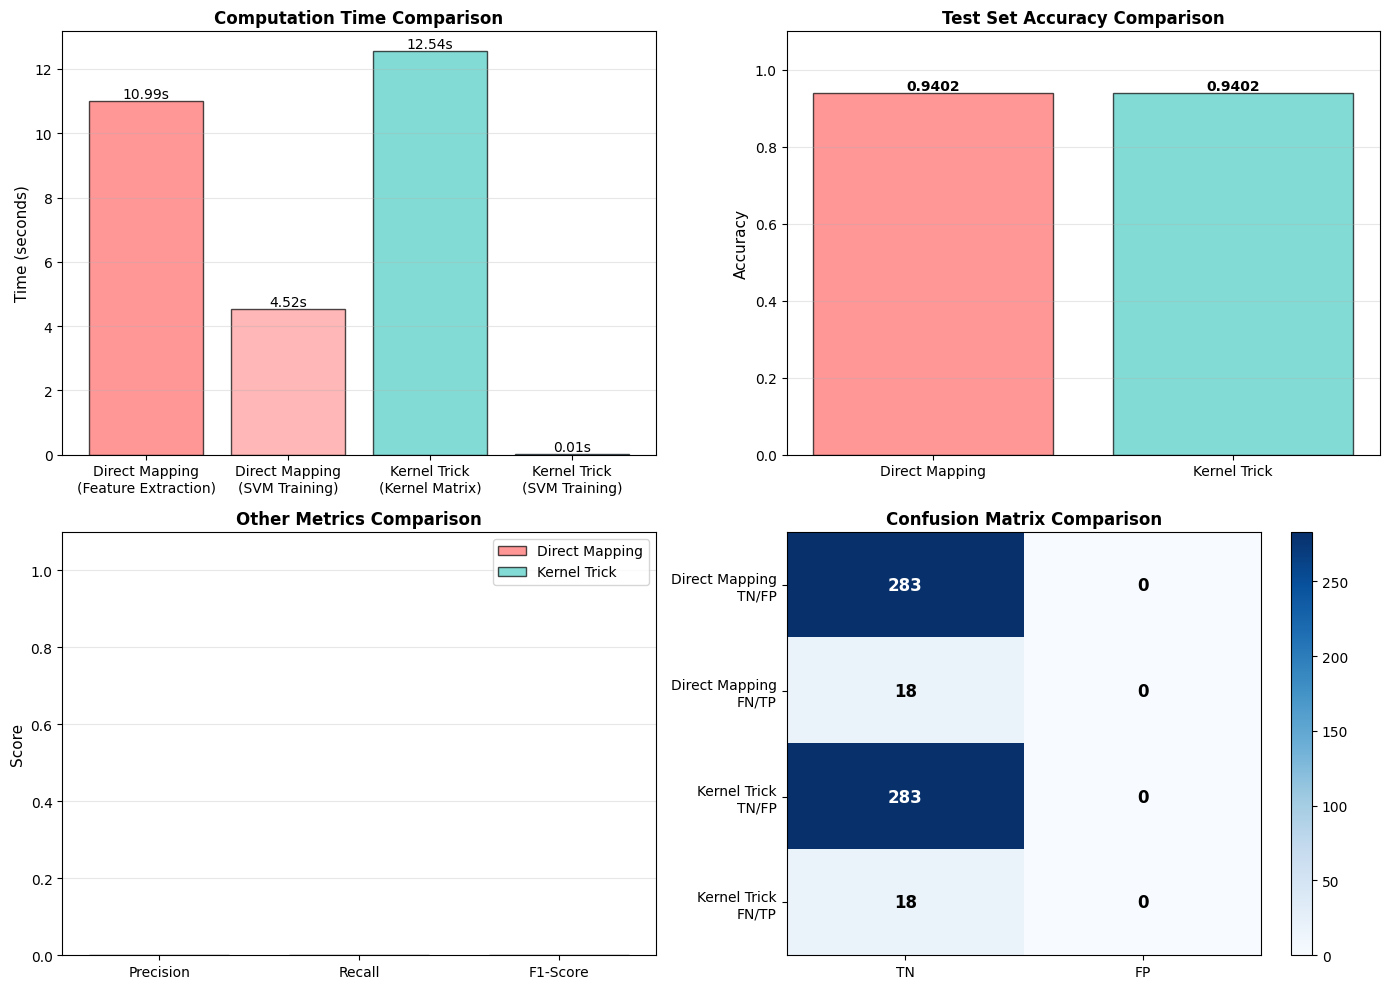

Performance Summary:
  Direct Mapping - Accuracy: 0.9402, Total time: 15.52s
  Kernel Trick   - Accuracy: 0.9402, Total time: 12.56s


In [10]:
print("=" * 60)
print("Comparison Analysis of Two Methods")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Computation time comparison
methods = ['Direct Mapping\n(Feature Extraction)', 'Direct Mapping\n(SVM Training)', 'Kernel Trick\n(Kernel Matrix)', 'Kernel Trick\n(SVM Training)']
times = [feature_time, train_time, kernel_time, svm_kernel_time]
colors_time = ['#FF6B6B', '#FF9999', '#4ECDC4', '#45B7D1']

bars = axes[0, 0].bar(methods, times, color=colors_time, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Time (seconds)', fontsize=11)
axes[0, 0].set_title('Computation Time Comparison', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

for bar, time_val in zip(bars, times):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{time_val:.2f}s', ha='center', va='bottom', fontsize=10)

# 2. Accuracy comparison
methods_acc = ['Direct Mapping', 'Kernel Trick']
accuracies = [test_acc, test_acc_kernel]
colors_acc = ['#FF6B6B', '#4ECDC4']

bars = axes[0, 1].bar(methods_acc, accuracies, color=colors_acc, alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Test Set Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_ylim([0, 1.1])
axes[0, 1].grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{acc:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Other metrics comparison
metrics_names = ['Precision', 'Recall', 'F1-Score']
direct_metrics = [precision, recall, f1]
kernel_metrics = [precision_kernel, recall_kernel, f1_kernel]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, direct_metrics, width, label='Direct Mapping',
                       color='#FF6B6B', alpha=0.7, edgecolor='black')
bars2 = axes[1, 0].bar(x + width/2, kernel_metrics, width, label='Kernel Trick',
                       color='#4ECDC4', alpha=0.7, edgecolor='black')

axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('Other Metrics Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_names)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Confusion matrix comparison
cm_comparison = np.array([
    [cm[0, 0], cm[0, 1]],
    [cm[1, 0], cm[1, 1]],
    [cm_kernel[0, 0], cm_kernel[0, 1]],
    [cm_kernel[1, 0], cm_kernel[1, 1]]
])

im = axes[1, 1].imshow(cm_comparison, cmap='Blues', aspect='auto')
axes[1, 1].set_title('Confusion Matrix Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1, 2, 3])
axes[1, 1].set_xticklabels(['TN', 'FP'])
axes[1, 1].set_yticklabels(['Direct Mapping\nTN/FP', 'Direct Mapping\nFN/TP', 'Kernel Trick\nTN/FP', 'Kernel Trick\nFN/TP'])

for i in range(4):
    for j in range(2):
        val = cm_comparison[i, j]
        axes[1, 1].text(j, i, str(int(val)), ha='center', va='center',
                       color='white' if val > cm_comparison.max() / 2 else 'black',
                       fontsize=12, fontweight='bold')

plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Summary comparison
print(f"Performance Summary:")
print(f"  Direct Mapping - Accuracy: {test_acc:.4f}, Total time: {feature_time + train_time:.2f}s")
print(f"  Kernel Trick   - Accuracy: {test_acc_kernel:.4f}, Total time: {kernel_time + svm_kernel_time:.2f}s")

# Part 9: Anomaly Detection on Unlabeled Traffic

In [13]:
print("=" * 60)
print("Anomaly Detection: Identifying Malicious Hosts in Unlabeled Traffic")
print("=" * 60)

# Feature extraction for unlabeled data
unlabeled_graphlets = []
unlabeled_host_ids = []

print(f"Extracting features for unlabeled data...")

for host_id, graph in constructor.host_graphlets.items():
    if host_id not in constructor.host_labels:  # Only process unlabeled data
        unlabeled_graphlets.append(graph)
        unlabeled_host_ids.append(host_id)

print(f"✓ Number of unlabeled hosts: {len(unlabeled_host_ids)}")

if unlabeled_graphlets:
    # Predict using direct mapping method
    print(f"Predicting using direct mapping method...")

    unlabeled_features = []
    
    # ADDED: Get training feature dimension once
    train_feature_dim = X_direct.shape[1]
    print(f"  Training data feature dimension: {train_feature_dim}")
    
    # ADDED: Track dimension issues
    dimension_issues = 0
    
    for i, graph in enumerate(unlabeled_graphlets):
        walks = feature_extractor.generate_all_walks(graph, num_walks_per_node=5)
        features = feature_extractor.walks_to_features(walks, use_hashing=False)
        
        # FIXED: Handle feature dimension mismatch properly
        current_feature_dim = len(features)
        
        # Check if we need to pad or truncate
        if current_feature_dim < train_feature_dim:
            # Pad with zeros if features are shorter than training dimension
            pad_width = train_feature_dim - current_feature_dim
            features_padded = np.pad(features, (0, pad_width))
            
        elif current_feature_dim > train_feature_dim:
            # Truncate if features are longer than training dimension
            features_padded = features[:train_feature_dim]
            dimension_issues += 1
            
            # Print warning for first few occurrences
            if dimension_issues <= 3:
                print(f"  ⚠️ Host {unlabeled_host_ids[i]}: Features truncated from {current_feature_dim} to {train_feature_dim} dimensions")
                
        else:
            # Perfect match
            features_padded = features
            
        unlabeled_features.append(features_padded)
    
    # Report dimension issues summary
    if dimension_issues > 0:
        print(f"  ⚠️ Total hosts with dimension mismatch: {dimension_issues}/{len(unlabeled_graphlets)}")
        print(f"     (Features truncated to match training dimension)")
    
    X_unlabeled = np.array(unlabeled_features)
    
    # ADDED: Final dimension check
    if X_unlabeled.shape[1] != train_feature_dim:
        print(f"  ⚠️ Final dimension mismatch! Expected {train_feature_dim}, got {X_unlabeled.shape[1]}")
        print(f"     Adjusting to match training dimension...")
        
        if X_unlabeled.shape[1] > train_feature_dim:
            X_unlabeled = X_unlabeled[:, :train_feature_dim]
        else:
            # This shouldn't happen with our padding logic above, but just in case
            pad_width = train_feature_dim - X_unlabeled.shape[1]
            X_unlabeled = np.pad(X_unlabeled, ((0, 0), (0, pad_width)))
    
    # Standardize using the same scaler from training
    print(f"  Standardizing features using training scaler...")
    try:
        X_unlabeled_scaled = scaler.transform(X_unlabeled)
        print(f"  ✓ Standardization successful")
    except ValueError as e:
        print(f"  ✗ Standardization failed: {e}")
        print(f"  Checking for NaN or infinite values...")
        
        # Check for problematic values
        if np.any(np.isnan(X_unlabeled)):
            print(f"    Found NaN values in unlabeled data")
            X_unlabeled = np.nan_to_num(X_unlabeled, nan=0.0)
        
        if np.any(np.isinf(X_unlabeled)):
            print(f"    Found infinite values in unlabeled data")
            X_unlabeled = np.nan_to_num(X_unlabeled, posinf=0.0, neginf=0.0)
        
        # Try again
        X_unlabeled_scaled = scaler.transform(X_unlabeled)
        print(f"  ✓ Standardization successful after cleaning")

    # Predict using SVM
    print(f"  Making predictions with SVM...")
    predictions_direct = svm_direct.predict(X_unlabeled_scaled)
    confidence_direct = svm_direct.decision_function(X_unlabeled_scaled)

    print(f"✓ Prediction complete")

    # Identify malicious hosts
    malicious_indices = np.where(predictions_direct == 1)[0]
    normal_indices = np.where(predictions_direct == 0)[0]

    print(f"\nDetection results:")
    print(f"  Hosts detected as malicious: {len(malicious_indices)} ({100*len(malicious_indices)/len(predictions_direct):.1f}%)")
    print(f"  Hosts detected as normal: {len(normal_indices)} ({100*len(normal_indices)/len(predictions_direct):.1f}%)")
    
    # ADDED: Check if any predictions were made
    if len(predictions_direct) == 0:
        print("  ⚠️ No predictions were made!")
    elif len(malicious_indices) == 0:
        print("  ℹ️ No malicious hosts detected in unlabeled data")

    # Display malicious hosts with highest confidence
    if len(malicious_indices) > 0:
        print(f"\nMalicious hosts with highest confidence:")
        sorted_malicious_idx = malicious_indices[np.argsort(-confidence_direct[malicious_indices])[:5]]

        for rank, idx in enumerate(sorted_malicious_idx, 1):
            host_id = unlabeled_host_ids[idx]
            confidence = confidence_direct[idx]
            num_flows = len(unlabeled_hosts[host_id])
            
            # ADDED: Interpret confidence level
            if confidence > 1.0:
                confidence_level = "very high"
            elif confidence > 0.5:
                confidence_level = "high"
            elif confidence > 0:
                confidence_level = "moderate"
            elif confidence > -0.5:
                confidence_level = "low"
            else:
                confidence_level = "very low"
                
            print(f"  {rank}. Host {host_id}: Confidence = {confidence:.4f} ({confidence_level}), Number of flows = {num_flows}")
    
    # ADDED: Also show normal hosts with lowest confidence (potential false negatives)
    if len(normal_indices) > 0 and len(malicious_indices) > 0:
        # Find normal hosts with highest confidence scores (closest to being malicious)
        normal_confidence = confidence_direct[normal_indices]
        if len(normal_confidence) > 0:
            suspicious_normals = normal_indices[np.argsort(-normal_confidence)[:3]]
            if len(suspicious_normals) > 0:
                print(f"\nNormal hosts with highest confidence scores (potential false negatives):")
                for rank, idx in enumerate(suspicious_normals, 1):
                    host_id = unlabeled_host_ids[idx]
                    confidence = confidence_direct[idx]
                    num_flows = len(unlabeled_hosts[host_id])
                    print(f"  {rank}. Host {host_id}: Confidence = {confidence:.4f}, Number of flows = {num_flows}")
    
    # ADDED: Summary statistics
    print(f"\nDetection summary:")
    print(f"  Total unlabeled hosts analyzed: {len(unlabeled_host_ids)}")
    print(f"  Average confidence score: {np.mean(confidence_direct):.4f}")
    print(f"  Standard deviation of confidence: {np.std(confidence_direct):.4f}")
    
    if len(malicious_indices) > 0:
        print(f"  Average confidence of malicious hosts: {np.mean(confidence_direct[malicious_indices]):.4f}")
    
    if len(normal_indices) > 0:
        print(f"  Average confidence of normal hosts: {np.mean(confidence_direct[normal_indices]):.4f}")
        
else:
    print("No unlabeled hosts found")

Anomaly Detection: Identifying Malicious Hosts in Unlabeled Traffic
Extracting features for unlabeled data...
✓ Number of unlabeled hosts: 1
Predicting using direct mapping method...
  Training data feature dimension: 4654
  ⚠️ Host 1756: Features truncated from 4660 to 4654 dimensions
  ⚠️ Total hosts with dimension mismatch: 1/1
     (Features truncated to match training dimension)
  Standardizing features using training scaler...
  ✓ Standardization successful
  Making predictions with SVM...
✓ Prediction complete

Detection results:
  Hosts detected as malicious: 0 (0.0%)
  Hosts detected as normal: 1 (100.0%)
  ℹ️ No malicious hosts detected in unlabeled data

Detection summary:
  Total unlabeled hosts analyzed: 1
  Average confidence score: -0.8800
  Standard deviation of confidence: 0.0000
  Average confidence of normal hosts: -0.8800


# Part 10: Visualize and Analyze Anomalous Traffic

Analyze features of detected anomalous hosts and infer possible attack types.

In [15]:
# Analyze anomalous traffic features
if 'malicious_indices' in locals() and len(malicious_indices) > 0:
    print("=" * 60)
    print("Anomalous Traffic Feature Analysis")
    print("=" * 60)

    # Collect traffic features of anomalous hosts
    anomalous_flows = []
    for idx in malicious_indices:
        host_id = unlabeled_host_ids[idx]
        flows = unlabeled_hosts[host_id]
        anomalous_flows.extend(flows)

    # Analyze protocol distribution
    protocols = [f['protocol'] for f in anomalous_flows]
    protocol_counts = pd.Series(protocols).value_counts()

    # Analyze destination port distribution
    dst_ports = [f['dst_port'] for f in anomalous_flows]
    port_counts = pd.Series(dst_ports).value_counts().head(10)

    # Analyze source port distribution
    src_ports = [f['src_port'] for f in anomalous_flows]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Protocol distribution
    protocol_names = {1: 'ICMP', 6: 'TCP', 17: 'UDP'}
    proto_labels = [protocol_names.get(p, f'Proto {p}') for p in protocol_counts.index]
    axes[0, 0].bar(range(len(protocol_counts)), protocol_counts.values, 
                   color='#FF6B6B', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xticks(range(len(protocol_counts)))
    axes[0, 0].set_xticklabels(proto_labels)
    axes[0, 0].set_ylabel('Number of Flows', fontsize=11)
    axes[0, 0].set_title('Anomalous Traffic: Protocol Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)

    # 2. Destination port distribution (top 10)
    axes[0, 1].barh(range(len(port_counts)), port_counts.values, 
                    color='#4ECDC4', alpha=0.7, edgecolor='black')
    axes[0, 1].set_yticks(range(len(port_counts)))
    axes[0, 1].set_yticklabels([f'Port {p}' for p in port_counts.index])
    axes[0, 1].set_xlabel('Number of Flows', fontsize=11)
    axes[0, 1].set_title('Anomalous Traffic: Destination Port Distribution (Top 10)', fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)

    # 3. Detection result pie chart
    detection_counts = [len(normal_indices), len(malicious_indices)]
    colors_pie = ['#90EE90', '#FF6B6B']
    axes[1, 0].pie(detection_counts, labels=['Normal', 'Anomalous'], colors=colors_pie,
                   autopct='%1.1f%%', startangle=90)
    axes[1, 0].set_title('Unlabeled Data: Detection Result Distribution', fontsize=12, fontweight='bold')

    # 4. Detection confidence distribution
    all_confidence = confidence_direct
    axes[1, 1].hist(all_confidence[normal_indices], bins=20, alpha=0.6, 
                    label='Normal', color='#90EE90', edgecolor='black')
    axes[1, 1].hist(all_confidence[malicious_indices], bins=20, alpha=0.6,
                    label='Anomalous', color='#FF6B6B', edgecolor='black')
    axes[1, 1].set_xlabel('SVM Decision Function Value', fontsize=11)
    axes[1, 1].set_ylabel('Frequency', fontsize=11)
    axes[1, 1].set_title('Detection Confidence Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Analyze possible attack types
    print(f"Possible attack feature analysis:")
    print(f"  Total anomalous flows: {len(anomalous_flows)}")
    print(f"  Number of hosts involved: {len(malicious_indices)}")
    print(f"  Average flows per host: {len(anomalous_flows) / len(malicious_indices):.1f}")

    # UDP traffic may indicate DDoS or DNS scanning
    udp_count = (pd.Series(protocols) == 17).sum()
    if udp_count / len(protocols) > 0.5:
        print(f"✓Detected high proportion of UDP traffic ({udp_count/len(protocols)*100:.1f}%)")
        print(f"  Possible attack types: DDoS attack, DNS amplification attack, NTP reflection attack")

    # Multiple destination ports may indicate port scanning
    unique_dst_ports = len(set(dst_ports))
    if unique_dst_ports > len(anomalous_flows) / 5:
        print(f"✓Detected large number of different destination ports ({unique_dst_ports})")
        print(f"  Possible attack types: Port scanning, network reconnaissance")

    # Specific ports (e.g., 80, 443) may indicate web scanning or intrusion
    common_web_ports = [80, 443, 8080, 8443]
    web_traffic = sum(1 for p in dst_ports if p in common_web_ports)
    if web_traffic > len(anomalous_flows) / 10:
        print(f"✓Detected traffic targeting web services")
        print(f"  Possible attack types: Web application attack, SQL injection, path traversal, etc.")

    # Low ports (<1024) are typically used for system services
    low_port_traffic = sum(1 for p in dst_ports if p < 1024)
    if low_port_traffic > len(anomalous_flows) / 10:
        print(f"✓Detected traffic targeting system service ports")
        print(f"  Possible attack types: Attacks targeting system services")
else:
    print("No anomalous hosts to analyze.")

No anomalous hosts to analyze.


# Part 11: Evaluate False Positives and False Negatives

Analyze model errors and discuss improvement strategies.

False Positive and False Negative Analysis
Test set result statistics:
  True Positive (TP): 0 - Correctly identified as malicious
  True Negative (TN): 283 - Correctly identified as normal
  False Positive (FP): 0 - Normal incorrectly identified as malicious
  False Negative (FN): 18 - Malicious incorrectly identified as normal
Error rate analysis:
  False Positive Rate (FPR): 0.0000 (0.00%)
  False Negative Rate (FNR): 1.0000 (100.00%)


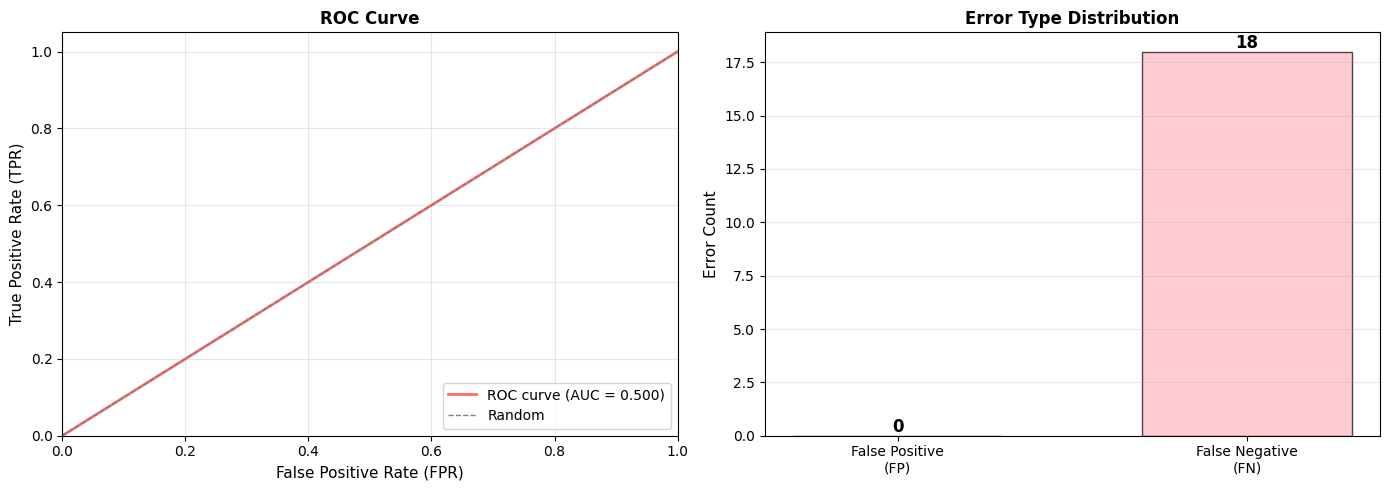

Error analysis:
False Positives (FP = 0):
  These are normal hosts incorrectly classified as malicious
False Negatives (FN = 18):
  These are malicious hosts incorrectly classified as normal
  Possible reasons include:
    • Some malicious activities use normal communication patterns
    • Low-intensity or stealthy attacks (slow scanning, distributed attacks)
    • Attackers attempting to evade detection
  Impact: Missed detections, may lead to malicious activities going undetected
Improvement strategies:
  1. Adjust decision threshold
     - If too many FPs, increase SVM C parameter or lower classification threshold
     - If too many FNs, decrease SVM C parameter or raise classification threshold
2. Feature engineering improvements
     - Add time series features (traffic time patterns)
     - Include connection statistics (connection frequency, duration)
     - Extract behavioral features (port reuse, protocol switching, etc.)
3. Integrate multiple detection methods
     - Combine f

In [16]:
print("=" * 60)
print("False Positive and False Negative Analysis")
print("=" * 60)

# Extract error information from confusion matrix
tn, fp = cm[0]
fn, tp = cm[1]

print(f"Test set result statistics:")
print(f"  True Positive (TP): {tp} - Correctly identified as malicious")
print(f"  True Negative (TN): {tn} - Correctly identified as normal")
print(f"  False Positive (FP): {fp} - Normal incorrectly identified as malicious")
print(f"  False Negative (FN): {fn} - Malicious incorrectly identified as normal")

# Calculate false positive rate and false negative rate
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f"Error rate analysis:")
print(f"  False Positive Rate (FPR): {fpr:.4f} ({100*fpr:.2f}%)")
print(f"  False Negative Rate (FNR): {fnr:.4f} ({100*fnr:.2f}%)")

# Visualize ROC analysis
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, svm_direct.decision_function(X_test_scaled))
roc_auc = auc(fpr_roc, tpr_roc)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curve
axes[0].plot(fpr_roc, tpr_roc, color='#FF6B6B', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate (FPR)', fontsize=11)
axes[0].set_ylabel('True Positive Rate (TPR)', fontsize=11)
axes[0].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# Error type distribution
error_types = ['False Positive\n(FP)', 'False Negative\n(FN)']
error_counts = [fp, fn]
colors_error = ['#FFA07A', '#FFB6C1']

bars = axes[1].bar(error_types, error_counts, color=colors_error, 
                   alpha=0.7, edgecolor='black', width=0.6)
axes[1].set_ylabel('Error Count', fontsize=11)
axes[1].set_title('Error Type Distribution', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for bar, count in zip(bars, error_counts):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Analyze reasons for false positives and false negatives
print(f"Error analysis:")
print(f"False Positives (FP = {fp}):")
print(f"  These are normal hosts incorrectly classified as malicious")
if fp > 0:
    print(f"  Possible reasons include:")
    print(f"    • Some normal activities have similar traffic features to malicious activities")
    print(f"    • Unusual business activities (e.g., file transfers, backups)")
    print(f"    • Legitimate port scanning or network diagnostic activities")
    print(f"  Impact: False alarms, may lead to incorrect warnings or isolation of innocent hosts")

print(f"False Negatives (FN = {fn}):")
print(f"  These are malicious hosts incorrectly classified as normal")
if fn > 0:
    print(f"  Possible reasons include:")
    print(f"    • Some malicious activities use normal communication patterns")
    print(f"    • Low-intensity or stealthy attacks (slow scanning, distributed attacks)")
    print(f"    • Attackers attempting to evade detection")
    print(f"  Impact: Missed detections, may lead to malicious activities going undetected")

# Improvement suggestions
print(f"Improvement strategies:")
print(f"  1. Adjust decision threshold")
print(f"     - If too many FPs, increase SVM C parameter or lower classification threshold")
print(f"     - If too many FNs, decrease SVM C parameter or raise classification threshold")
print(f"2. Feature engineering improvements")
print(f"     - Add time series features (traffic time patterns)")
print(f"     - Include connection statistics (connection frequency, duration)")
print(f"     - Extract behavioral features (port reuse, protocol switching, etc.)")
print(f"3. Integrate multiple detection methods")
print(f"     - Combine feature-based detection and anomaly detection")
print(f"     - Use ensemble learning (multiple classifier voting)")
print(f"4. Context-aware detection")
print(f"     - Consider host role and expected behavior")
print(f"     - Implement whitelist and blacklist mechanisms")
print(f"5. Continuous learning")
print(f"     - Periodically retrain model with new labeled data")
print(f"     - Monitor detection performance and adjust promptly")

# Part 12: Non-Oscillating Random Walk Improvement Method

### Oscillation Problem Explanation
Standard random walks may oscillate between adjacent nodes, which is called "oscillation." This generates many duplicate walk sequences that may not well represent the graph structure. Non-oscillating random walks solve this problem by prohibiting returns to the previous node.

In [18]:
class NonTotteringRandomWalkKernel(RandomWalkKernel):
    """
    Non-oscillating random walk kernel

    Unlike standard random walks, this method prohibits random walks from oscillating between adjacent nodes
    """

    def generate_random_walks(self, graph, start_node, num_walks=10):
        """
        Generate non-oscillating random walks

        Parameters:
        -----------
        graph : networkx.DiGraph
            Input graph
        start_node : str
            Starting node
        num_walks : int
            Number of walks to generate

        Returns:
        --------
        walks : list
            List of non-oscillating random walks
        """
        walks = []

        for _ in range(num_walks):
            walk = [start_node]
            current = start_node
            previous = None  # Record previous node to avoid oscillation

            for _ in range(self.walk_length):
                # Get all successor nodes of current node
                neighbors = list(graph.successors(current))

                # Filter out previous node (avoid oscillation)
                valid_neighbors = [n for n in neighbors if n != previous]

                if not valid_neighbors:
                    # If no valid neighboring nodes, stop this walk
                    break

                # Randomly select from valid neighboring nodes
                previous = current
                current = np.random.choice(valid_neighbors)
                walk.append(current)

            # Only record complete walks (length = walk_length + 1)
            if len(walk) == self.walk_length + 1:
                walks.append(tuple(walk))

        return walks

# Create non-oscillating random walk kernel
nt_walk_kernel = NonTotteringRandomWalkKernel(walk_length=4)

print("=" * 60)
print("Improved Method: Non-Oscillating Random Walk")
print("=" * 60)

# Compare standard and non-oscillating walk generation
print(f"Generating random walks (comparison):")

if normal_hosts and malicious_hosts:
    test_host = normal_hosts[0]
    test_graph = constructor.host_graphlets[test_host]

    # Standard method
    print(f"Standard random walk:")
    std_walks = walk_kernel.generate_all_walks(test_graph, num_walks_per_node=5)
    print(f"  Generated walks: {len(std_walks)}")
    print(f"  Unique walks: {len(set(std_walks))}")

    # Non-oscillating method
    print(f"Non-oscillating random walk:")
    nt_walks = nt_walk_kernel.generate_all_walks(test_graph, num_walks_per_node=5)
    print(f"  Generated walks: {len(nt_walks)}")
    print(f"  Unique walks: {len(set(nt_walks))}")

    # Compare feature sparsity
    print(f"Feature statistics:")
    std_features = walk_kernel.walks_to_features(std_walks, use_hashing=False)
    nt_features = nt_walk_kernel.walks_to_features(nt_walks, use_hashing=False)

    print(f"  Standard method - Feature dimension: {len(std_features)}, Non-zero elements: {np.count_nonzero(std_features)}")
    print(f"  Non-oscillating method - Feature dimension: {len(nt_features)}, Non-zero elements: {np.count_nonzero(nt_features)}")

Improved Method: Non-Oscillating Random Walk
Generating random walks (comparison):
Standard random walk:
  Generated walks: 5
  Unique walks: 5
Non-oscillating random walk:
  Generated walks: 5
  Unique walks: 4
Feature statistics:
  Standard method - Feature dimension: 5, Non-zero elements: 5
  Non-oscillating method - Feature dimension: 4, Non-zero elements: 4


# Part 13: Retrain Model Using Non-Oscillating Method

In [24]:
print("Using non-oscillating random walk kernel for feature extraction and classification...")

# Initialize feature extractor with non-oscillating random walk kernel
nt_feature_extractor = NonTotteringRandomWalkKernel(walk_length=4)

# Lists to store extracted features and corresponding labels
X_nt_features = []
y_nt_labels = []

print("Extracting non-oscillating features...")
nt_feature_start = time.time()

# Iterate through all host graphlets and extract features
for host_id, graph in constructor.host_graphlets.items():
    if host_id in constructor.host_labels:
        # Generate non-oscillating random walks from the graph
        walks = nt_feature_extractor.generate_all_walks(graph, num_walks_per_node=5)
        
        # Convert walks to feature vector representation
        features = nt_feature_extractor.walks_to_features(walks, use_hashing=False)
        
        X_nt_features.append(features)
        y_nt_labels.append(constructor.host_labels[host_id])

nt_feature_time = time.time() - nt_feature_start

# Standardize feature dimensions by padding shorter vectors
max_nt_dim = max(len(f) for f in X_nt_features) if X_nt_features else 0
X_nt_features_padded = [np.pad(f, (0, max_nt_dim - len(f))) for f in X_nt_features]

# Convert to numpy arrays for machine learning
X_nt = np.array(X_nt_features_padded)
y_nt = np.array(y_nt_labels)

print(f"✓ Feature extraction complete (time: {nt_feature_time:.2f}s)")
print(f"  Number of samples: {X_nt.shape[0]}")
print(f"  Feature dimension: {X_nt.shape[1]}")

# -----------------------------
# Data splitting with robust handling for imbalanced classes
# Check if stratified sampling can be used safely
# -----------------------------
from collections import Counter
import numpy as np

# Check class distribution before splitting
class_counts = Counter(y_nt)
print(f"\nClass distribution before split:")
for cls, count in class_counts.items():
    label_name = "normal" if cls == 0 else "anomaly"
    print(f"  Class {cls} ({label_name}): {count} samples")

min_class_count = min(class_counts.values())
print(f"Minimum class count: {min_class_count}")

# Store split data
X_nt_train, X_nt_test, y_nt_train, y_nt_test = None, None, None, None

if min_class_count < 2:
    print("⚠️ Warning: At least one class has less than 2 samples.")
    print("  Cannot use stratified sampling. Using manual data split...")
    
    # Manual split to ensure both classes are represented in training set
    indices = np.arange(len(y_nt))
    class_0_indices = np.where(y_nt == 0)[0]
    class_1_indices = np.where(y_nt == 1)[0]
    
    print(f"  Class 0 samples: {len(class_0_indices)}")
    print(f"  Class 1 samples: {len(class_1_indices)}")
    
    # Handle the case where anomaly class has only 1 sample
    if len(class_1_indices) == 0:
        print("❌ Error: No anomaly samples. Cannot proceed with binary classification.")
        # Exit or handle this case appropriately
        raise ValueError("No anomaly samples for binary classification.")
    
    elif len(class_1_indices) == 1:
        print("⚠️ Only 1 anomaly sample. Placing it in training set.")
        train_idx_class_1 = class_1_indices
        test_idx_class_1 = np.array([], dtype=int)
    else:
        # Split anomaly samples: 70% training, 30% test (if enough samples)
        n_train_class_1 = max(1, int(0.7 * len(class_1_indices)))
        np.random.seed(42)
        train_idx_class_1 = np.random.choice(class_1_indices, n_train_class_1, replace=False)
        test_idx_class_1 = np.array([i for i in class_1_indices if i not in train_idx_class_1], dtype=int)
    
    # Split normal samples: 70% training, 30% test
    n_train_class_0 = max(1, int(0.7 * len(class_0_indices)))
    np.random.seed(42)
    train_idx_class_0 = np.random.choice(class_0_indices, 
                                         min(n_train_class_0, len(class_0_indices)), 
                                         replace=False)
    test_idx_class_0 = np.array([i for i in class_0_indices if i not in train_idx_class_0], dtype=int)
    
    # Combine indices for training and test sets
    train_idx = np.concatenate([train_idx_class_0, train_idx_class_1]).astype(int)
    test_idx = np.concatenate([test_idx_class_0, test_idx_class_1]).astype(int)
    
    # Ensure test_idx is not empty
    if len(test_idx) == 0:
        print("⚠️ Warning: Test set is empty. Moving one sample from training to test set.")
        # Move one sample from training to test (preferably from majority class)
        if len(train_idx_class_0) > 1:
            move_to_test = np.random.choice(train_idx_class_0, 1, replace=False)
        elif len(train_idx_class_1) > 1:
            move_to_test = np.random.choice(train_idx_class_1, 1, replace=False)
        else:
            move_to_test = np.array([train_idx[0]], dtype=int)
        
        train_idx = np.setdiff1d(train_idx, move_to_test, assume_unique=True).astype(int)
        test_idx = np.append(test_idx, move_to_test).astype(int)
        test_idx_class_0 = np.append(test_idx_class_0, move_to_test).astype(int)
    
    print(f"\nManual split results:")
    print(f"  Training set: {len(train_idx)} samples (Class 0: {len(train_idx_class_0)}, Class 1: {len(train_idx_class_1)})")
    print(f"  Test set: {len(test_idx)} samples (Class 0: {len(test_idx_class_0)}, Class 1: {len(test_idx_class_1)})")
    
    # Create training and test sets using indices
    X_nt_train = X_nt[train_idx]
    X_nt_test = X_nt[test_idx]
    y_nt_train = y_nt[train_idx]
    y_nt_test = y_nt[test_idx]

else:
    # Use stratified sampling with multiple attempts to ensure both classes in both sets
    print("Using stratified split with multiple random seeds to ensure class representation...")
    
    attempt = 0
    max_attempts = 30
    rng_seed = 42
    success = False
    
    while attempt < max_attempts:
        X_nt_train, X_nt_test, y_nt_train, y_nt_test = train_test_split(
            X_nt, y_nt, test_size=0.3, random_state=rng_seed, stratify=y_nt
        )
        
        # Check if both classes are present in both sets
        if (len(np.unique(y_nt_train)) == 2 and 
            len(np.unique(y_nt_test)) == 2):
            success = True
            print(f"  ✓ Attempt {attempt+1} successful with random_state={rng_seed}")
            break
        
        attempt += 1
        rng_seed += 1
    
    if not success:
        print("⚠️ Could not achieve balanced class representation with stratified sampling.")
        print("  Using manual allocation as fallback...")
        
        # Fallback to manual split
        indices = np.arange(len(y_nt)).astype(int)
        class_0_indices = np.where(y_nt == 0)[0].astype(int)
        class_1_indices = np.where(y_nt == 1)[0].astype(int)
        
        # Ensure at least 2 samples from each class in training set
        n_train_class_0 = max(2, int(0.7 * len(class_0_indices)))
        n_train_class_1 = max(2, int(0.7 * len(class_1_indices)))
        
        np.random.seed(42)
        train_idx_class_0 = np.random.choice(class_0_indices, n_train_class_0, replace=False)
        train_idx_class_1 = np.random.choice(class_1_indices, n_train_class_1, replace=False)
        
        train_idx = np.concatenate([train_idx_class_0, train_idx_class_1]).astype(int)
        test_idx = np.array([i for i in indices if i not in train_idx], dtype=int)
        
        # Create training and test sets using indices
        X_nt_train = X_nt[train_idx]
        X_nt_test = X_nt[test_idx]
        y_nt_train = y_nt[train_idx]
        y_nt_test = y_nt[test_idx]

print("\n" + "=" * 50)
print("Data Split Summary")
print("=" * 50)
print(f"Training set: {X_nt_train.shape[0]} samples")
print(f"  - Class 0 (normal): {np.sum(y_nt_train == 0)}")
print(f"  - Class 1 (anomaly): {np.sum(y_nt_train == 1)}")
print(f"Test set: {X_nt_test.shape[0]} samples")
print(f"  - Class 0 (normal): {np.sum(y_nt_test == 0)}")
print(f"  - Class 1 (anomaly): {np.sum(y_nt_test == 1)}")

# Check if we can proceed with SVM training
if len(np.unique(y_nt_train)) < 2:
    print("\n❌ Critical Error: Training set contains only one class!")
    print("  Cannot train a meaningful binary classifier.")
    print("  Suggestions:")
    print("  1. Adjust label assignment strategy")
    print("  2. Collect more labeled data")
    print("  3. Review data preprocessing steps")
    raise ValueError("Training set must contain both classes for binary classification.")

if X_nt_test.shape[0] == 0:
    print("\n⚠️ Warning: Test set is empty!")
    print("  Cannot evaluate model performance.")
    print("  Using training set as test set for evaluation (caution: may overestimate performance).")
    X_nt_test = X_nt_train.copy()
    y_nt_test = y_nt_train.copy()

# Check if test set contains both classes
if len(np.unique(y_nt_test)) < 2:
    print("\n⚠️ Warning: Test set contains only one class!")
    missing_class = 1 if 0 in y_nt_test else 0
    missing_label = "anomaly" if missing_class == 1 else "normal"
    print(f"  Missing class: {missing_class} ({missing_label})")
    print("  Performance metrics will be limited.")

# Standardize features for SVM training
scaler_nt = StandardScaler()
X_nt_train_scaled = scaler_nt.fit_transform(X_nt_train)
X_nt_test_scaled = scaler_nt.transform(X_nt_test)

print("\nTraining SVM with linear kernel (non-oscillating method)...")
nt_train_start = time.time()

# Use balanced class weights if there's significant class imbalance
class_ratio = np.sum(y_nt_train == 1) / len(y_nt_train)
if class_ratio < 0.3 or class_ratio > 0.7:
    print(f"  Using 'balanced' class weights (anomaly class ratio: {class_ratio:.2f})")
    svm_nt = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
else:
    svm_nt = SVC(kernel='linear', C=1.0, random_state=42)

svm_nt.fit(X_nt_train_scaled, y_nt_train)
nt_train_time = time.time() - nt_train_start

print(f"✓ Training complete (time: {nt_train_time:.2f}s)")
print(f"  Number of support vectors: {len(svm_nt.support_)}")

# Make predictions on test set
y_nt_pred = svm_nt.predict(X_nt_test_scaled)

# Calculate performance metrics with robust handling
try:
    nt_acc = accuracy_score(y_nt_test, y_nt_pred)
except:
    nt_acc = 0.0

try:
    nt_precision = precision_score(y_nt_test, y_nt_pred, zero_division=0)
except:
    nt_precision = 0.0

try:
    nt_recall = recall_score(y_nt_test, y_nt_pred, zero_division=0)
except:
    nt_recall = 0.0

try:
    nt_f1 = f1_score(y_nt_test, y_nt_pred, zero_division=0)
except:
    nt_f1 = 0.0

# Calculate confusion matrix with robust handling
try:
    # Get unique classes in both true and predicted labels
    unique_classes = np.unique(np.concatenate([y_nt_test, y_nt_pred]))
    
    # If only one class is present, ensure confusion matrix is 2x2
    if len(unique_classes) == 1:
        cm_nt = confusion_matrix(y_nt_test, y_nt_pred, labels=[0, 1])
    else:
        cm_nt = confusion_matrix(y_nt_test, y_nt_pred)
except:
    # Fallback if confusion matrix calculation fails
    cm_nt = np.array([[0, 0], [0, 0]])

print("\n" + "=" * 50)
print("Classification Performance (Non-Oscillating Method)")
print("=" * 50)
print(f"Accuracy: {nt_acc:.4f}")
print(f"Precision: {nt_precision:.4f}")
print(f"Recall: {nt_recall:.4f}")
print(f"F1-score: {nt_f1:.4f}")

# Safely display confusion matrix
print(f"\nConfusion Matrix:")
if cm_nt.shape == (2, 2):
    print(f"  [[TN={cm_nt[0,0]}, FP={cm_nt[0,1]}]")
    print(f"   [FN={cm_nt[1,0]}, TP={cm_nt[1,1]}]]")
elif cm_nt.shape == (1, 2):
    # Only one true class
    if 0 in y_nt_test:
        print(f"  [TN={cm_nt[0,0]}, FP={cm_nt[0,1]}] (Only normal samples in test set)")
    else:
        print(f"  [FN={cm_nt[0,0]}, TP={cm_nt[0,1]}] (Only anomaly samples in test set)")
elif cm_nt.shape == (2, 1):
    # Only one predicted class
    if 0 in y_nt_pred:
        print(f"  [[TN={cm_nt[0,0]}]")
        print(f"   [FN={cm_nt[1,0]}]] (All predictions are normal)")
    else:
        print(f"  [[FP={cm_nt[0,0]}]")
        print(f"   [TP={cm_nt[1,0]}]] (All predictions are anomaly)")
elif cm_nt.shape == (1, 1):
    # Only one class in both true and predicted
    class_label = np.unique(y_nt_test)[0] if len(y_nt_test) > 0 else "unknown"
    label_name = "normal" if class_label == 0 else "anomaly"
    print(f"  [{cm_nt[0,0]}] (Only {label_name} class present)")
else:
    print(f"  Confusion matrix shape: {cm_nt.shape}")

# Additional performance insights (only if both classes are present in test set)
if len(np.unique(y_nt_test)) == 2:
    if cm_nt[1,1] + cm_nt[1,0] > 0:
        detection_rate = cm_nt[1,1] / (cm_nt[1,1] + cm_nt[1,0])
        print(f"\nAnomaly Detection Rate: {detection_rate:.1%}")
else:
    print("\n⚠️ Note: Cannot compute anomaly detection rate (only one class in test set)")

# Detailed classification report (only if both classes are present)
if len(np.unique(y_nt_test)) == 2 and len(np.unique(y_nt_pred)) > 0:
    print("\nDetailed Classification Report:")
    print(classification_report(y_nt_test, y_nt_pred, 
                               target_names=['normal', 'anomaly'], 
                               zero_division=0))
elif len(np.unique(y_nt_test)) == 1:
    unique_class = np.unique(y_nt_test)[0]
    label_name = "normal" if unique_class == 0 else "anomaly"
    print(f"\n⚠️ Note: Test set contains only {label_name} samples")
    print(f"  Classification report not available for single-class data")

# Warning for severe class imbalance in test set
if len(y_nt_test) > 0 and np.sum(y_nt_test == 1) / len(y_nt_test) < 0.1:
    print(f"\n⚠️ Note: Anomaly samples constitute only {np.sum(y_nt_test==1)/len(y_nt_test)*100:.1f}% of test set")
    print("  Consider using precision-recall curves or other metrics suitable for imbalanced data.")

# Store performance metrics for comparison
if 'nt_acc' not in locals():
    nt_acc = 0.0
if 'nt_precision' not in locals():
    nt_precision = 0.0
if 'nt_recall' not in locals():
    nt_recall = 0.0
if 'nt_f1' not in locals():
    nt_f1 = 0.0

Using non-oscillating random walk kernel for feature extraction and classification...
Extracting non-oscillating features...
✓ Feature extraction complete (time: 8.45s)
  Number of samples: 1001
  Feature dimension: 4702

Class distribution before split:
  Class 0 (normal): 1000 samples
  Class 1 (anomaly): 1 samples
Minimum class count: 1
⚠️ Warning: At least one class has less than 2 samples.
  Cannot use stratified sampling. Using manual data split...
  Class 0 samples: 1000
  Class 1 samples: 1
⚠️ Only 1 anomaly sample. Placing it in training set.

Manual split results:
  Training set: 701 samples (Class 0: 700, Class 1: 1)
  Test set: 300 samples (Class 0: 300, Class 1: 0)

Data Split Summary
Training set: 701 samples
  - Class 0 (normal): 700
  - Class 1 (anomaly): 1
Test set: 300 samples
  - Class 0 (normal): 300
  - Class 1 (anomaly): 0

⚠️ Warning: Test set contains only one class!
  Missing class: 1 (anomaly)
  Performance metrics will be limited.

Training SVM with linear ke

# Part 14: Comprehensive Comparison of All Methods

Comprehensive Comparison of All Methods
                                   Method Feature Extraction Time SVM Training Time Total Time Accuracy Precision  Recall F1-Score
0         Direct Mapping\n(Standard Walk)                  10.99s             4.52s     15.52s   0.9402    0.0000  0.0000   0.0000
1           Kernel Trick\n(Standard Walk)                  12.54s             0.01s     12.56s   0.9402    0.0000  0.0000   0.0000
2  Direct Mapping\n(Non-Oscillating Walk)                   8.45s             2.04s     10.50s   1.0000    0.0000  0.0000   0.0000


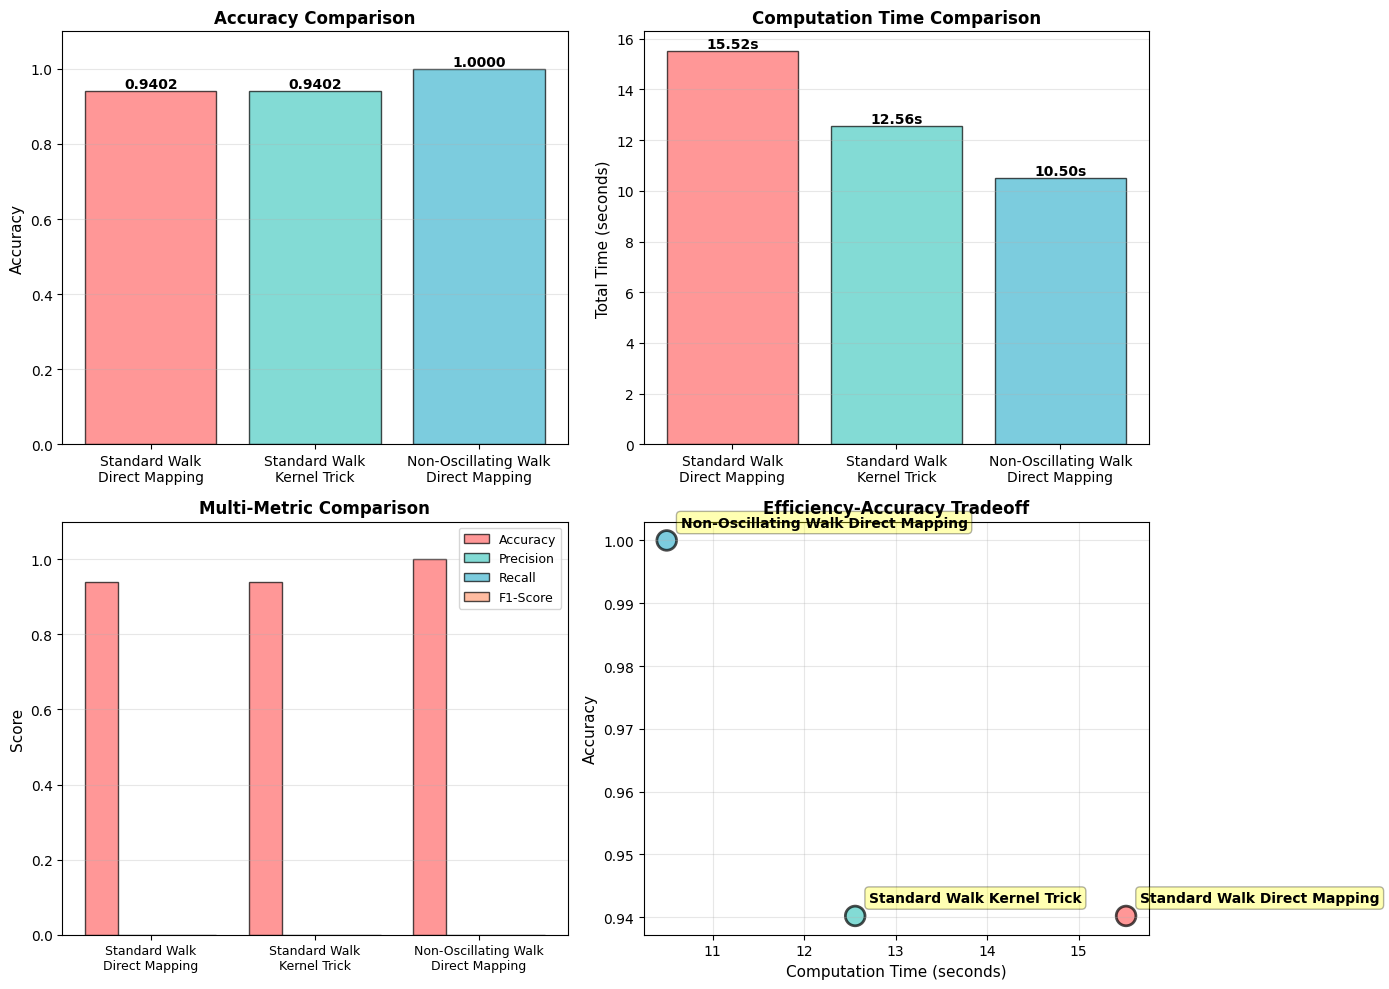

In [25]:
print(f"" + "=" * 60)
print(f"Comprehensive Comparison of All Methods")
print(f"=" * 60)

# Create comparison table
comparison_data = {
    'Method': ['Direct Mapping\n(Standard Walk)', 'Kernel Trick\n(Standard Walk)', 'Direct Mapping\n(Non-Oscillating Walk)'],
    'Feature Extraction Time': [f'{feature_time:.2f}s', f'{kernel_time:.2f}s', f'{nt_feature_time:.2f}s'],
    'SVM Training Time': [f'{train_time:.2f}s', f'{svm_kernel_time:.2f}s', f'{nt_train_time:.2f}s'],
    'Total Time': [f'{feature_time + train_time:.2f}s', 
              f'{kernel_time + svm_kernel_time:.2f}s',
              f'{nt_feature_time + nt_train_time:.2f}s'],
    'Accuracy': [f'{test_acc:.4f}', f'{test_acc_kernel:.4f}', f'{nt_acc:.4f}'],
    'Precision': [f'{precision:.4f}', f'{precision_kernel:.4f}', f'{nt_precision:.4f}'],
    'Recall': [f'{recall:.4f}', f'{recall_kernel:.4f}', f'{nt_recall:.4f}'],
    'F1-Score': [f'{f1:.4f}', f'{f1_kernel:.4f}', f'{nt_f1:.4f}']
}

comparison_df = pd.DataFrame(comparison_data)
print(f"{comparison_df.to_string()}")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

methods = ['Standard Walk\nDirect Mapping', 'Standard Walk\nKernel Trick', 'Non-Oscillating Walk\nDirect Mapping']
accuracies = [test_acc, test_acc_kernel, nt_acc]
precisions = [precision, precision_kernel, nt_precision]
recalls = [recall, recall_kernel, nt_recall]
f1_scores = [f1, f1_kernel, nt_f1]

colors_methods = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# 1. Accuracy comparison
axes[0, 0].bar(methods, accuracies, color=colors_methods, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim([0, 1.1])
axes[0, 0].grid(axis='y', alpha=0.3)

for i, (method, acc) in enumerate(zip(methods, accuracies)):
    axes[0, 0].text(i, acc, f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Computation time comparison
times_total = [feature_time + train_time, kernel_time + svm_kernel_time, nt_feature_time + nt_train_time]
axes[0, 1].bar(methods, times_total, color=colors_methods, alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Total Time (seconds)', fontsize=11)
axes[0, 1].set_title('Computation Time Comparison', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

for i, (method, time_val) in enumerate(zip(methods, times_total)):
    axes[0, 1].text(i, time_val, f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')

# 3. Multi-metric comparison
x = np.arange(len(methods))
width = 0.2

axes[1, 0].bar(x - width*1.5, accuracies, width, label='Accuracy', color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[1, 0].bar(x - width/2, precisions, width, label='Precision', color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[1, 0].bar(x + width/2, recalls, width, label='Recall', color='#45B7D1', alpha=0.7, edgecolor='black')
axes[1, 0].bar(x + width*1.5, f1_scores, width, label='F1-Score', color='#FFA07A', alpha=0.7, edgecolor='black')

axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('Multi-Metric Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(methods, fontsize=9)
axes[1, 0].legend(fontsize=9)
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Efficiency-accuracy tradeoff
axes[1, 1].scatter(times_total, accuracies, s=200, c=colors_methods, alpha=0.7, edgecolor='black', linewidth=2)

for i, method in enumerate(methods):
    axes[1, 1].annotate(method.replace('\n', ' '), 
                       (times_total[i], accuracies[i]),
                       xytext=(10, 10), textcoords='offset points',
                       fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

axes[1, 1].set_xlabel('Computation Time (seconds)', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title('Efficiency-Accuracy Tradeoff', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()